# BigQuery Churn Analysis

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
from sklearn.semi_supervised import LabelPropagation

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [32]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(df.columns):
    if col == "Type":
      continue
    plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")

  plt.tight_layout()
  plt.show()

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(12,15))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,4, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = Pipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = Pipeline(
    steps =[
      ("scaler", RobustScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor,model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearnPipeline(steps=steps)

def create_sampling_pipeline(preprocessor, sampling_model, model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("sample", sampling_model),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(2, ("Feature Selection", kbest))
  
  return Pipeline(steps=steps)

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(14, 10))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  return performance_df

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "CAT": CatBoostClassifier(verbose=0),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='weighted')
    precision_metric = precision_score(y, predictions, average='weighted')
    f1_metric = f1_score(y, predictions, average='weighted')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]
def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, sample_model=None, kbest=None):
  means, variances, std_devs, test_accs, recalls, precisions, f1_scores = [], [], [], [], [], [], []
  metric_tracker = []
  for model, model_name in zip(models, model_names):
    if kbest:
        pipeline = create_sampling_pipeline(preprocessor, sample_model, model, kbest)
    else:
        pipeline = create_sklearn_pipeline(preprocessor, model)
    
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
    
    means.append(scores[0])
    variances.append(scores[1])
    std_devs.append(scores[2])
    test_accs.append(scores[3])
    recalls.append(scores[4])
    precisions.append(scores[5])
    f1_scores.append(scores[6])
    
  plt.figure(figsize=(12, 8))
  models_index = range(len(model_names)) 
  plt.plot(models_index, means, marker='o', label='Mean')
  plt.plot(models_index, test_accs, marker='^', label='Test Accuracy')
  plt.plot(models_index, f1_scores, marker='s', label='F1 Score')
  plt.xticks(models_index, model_names, rotation=45) 
  plt.xlabel('Models')
  plt.ylabel('Scores')
  plt.title('Comparison of Model Performance')
  plt.legend()
  plt.grid(True)
  plt.show()
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  return performance_df

def test_kbest_columns(preprocessor, X, y, sample_model, model, model_name, kbest):
  acc_scores = []
  f1_scores = []
  recall_scores = []
  precision_scores = []
  ks = []
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sampling_pipeline(preprocessor, sample_model, model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    all_transformed_features = pipeline.named_steps['preprocessor'].get_feature_names_out()
    selected_mask = pipeline.named_steps["Feature Selection"].get_support()
    selected_features = all_transformed_features[selected_mask]
    
    cleaned_features = [col.replace("numeric__", "").replace("cat__", "") for col in selected_features]

    ks.append(k)
    acc_scores.append(acc)
    f1_scores.append(f1_metric)
    recall_scores.append(recall_metric)
    precision_scores.append(precision_metric)
    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "Selected Featured":", ".join(cleaned_features),
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  plt.figure(figsize=(10, 8))
  plt.plot(ks, acc_scores, marker='o', label='Accuracy')
  plt.plot(ks, f1_scores, marker='o', label='F1 Score')
  plt.plot(ks, recall_scores, marker='o', label='Recall')
  plt.plot(ks, precision_scores, marker='o', label='Precision')
  plt.xlabel('Number of Features Selected (k)')
  plt.ylabel('Score')
  plt.title('Model Performance Metrics vs. Number of Features')
  plt.legend()
  plt.grid(True)
  plt.show()
  return pd.DataFrame(metric_tracker)

def optimization_search(preprocessor, sample_model, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  best_models = []
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sampling_pipeline(preprocessor,sample_model, model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=15, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    plot_confusion_matrix(y_test, y_pred, model_name)
    best_models.append(best_model)
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return [pd.DataFrame(metric_tracker).sort_values(by="F1-Score", ascending=False), best_models]

def test_stacking_models(X, y, models, model_names):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  for model_name, model in zip(model_names, models):
  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker).sort_values(by="Test-Acc", ascending=False)

def get_feature_names(column_transformer):
    """Get feature names from all transformers in ColumnTransformer."""
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(pipe, 'named_steps'): 
                if 'Encoder' in pipe.named_steps: 
                    feature_names = pipe.named_steps['Encoder'].get_feature_names_out(features)
                    output_features.extend(feature_names)
                else:
                    output_features.extend(features)
            else:
                output_features.extend(features)
        else:
            output_features.extend(features)
    return output_features

# EDA

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/churn.csv")
df

,customer_id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,932aff1e-186f-418c-8716-28bba167c384,NY,86,area_code_510,False,False,0,70.7,125,12.02,...,113,17.94,174.6,107,7.86,0.0,0,0.00,2,False
1,143a0b05-b95a-4d00-ad2a-9c1b18234c29,VT,165,area_code_510,False,False,0,242.9,126,41.29,...,65,17.83,228.4,126,10.28,0.0,0,0.00,1,False
2,45debf35-7e4d-42da-ba4e-d737a8997e16,KS,70,area_code_415,False,False,0,222.8,114,37.88,...,113,18.35,223.5,122,10.06,0.0,0,0.00,1,False
3,76b4b68f-1113-4411-88ad-de38b482e9fb,NM,158,area_code_408,False,False,0,172.4,114,29.31,...,69,21.81,235.3,104,10.59,0.0,0,0.00,2,False
4,6ee9cecd-1a09-4f4a-937e-aa848c392bed,ND,101,area_code_415,False,False,0,217.7,118,37.01,...,128,19.69,185.3,128,8.34,0.0,0,0.00,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,e1db5067-6484-4a5d-b68d-ab869fff027d,UT,36,area_code_415,False,True,16,149.4,111,25.40,...,113,11.20,132.7,87,5.97,6.7,2,1.81,0,False
4246,99ad8c1e-c90b-44d5-ad36-d4d87aae0d85,MN,24,area_code_510,False,True,25,164.9,110,28.03,...,105,17.79,231.2,55,10.40,6.7,9,1.81,1,False
4247,b2287275-f563-40ae-ad9c-06844ca539f4,DE,97,area_code_415,False,True,32,183.4,94,31.18,...,120,22.87,203.5,38,9.16,6.7,4,1.81,5,False
4248,9908263a-a9c9-48f5-9c26-ca7cc9bd5917,IN,81,area_code_408,False,True,46,168.3,124,28.61,...,103,23.03,222.5,98,10.01,6.7,2,1.81,4,False


In [4]:
df["area_code"].value_counts()

area_code_415    2108
area_code_408    1086
area_code_510    1056
Name: area_code, dtype: int64

In [5]:
len(df["state"].unique())

51

In [6]:
df.drop(["state", "customer_id"],axis=1, inplace=True)

# Check For Nulls And Dupes

In [7]:
check_for_nulls_dupes(df)

The amount of Null Values: account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64
The amount of Duplicated Values 0


# Check Class Imbalance

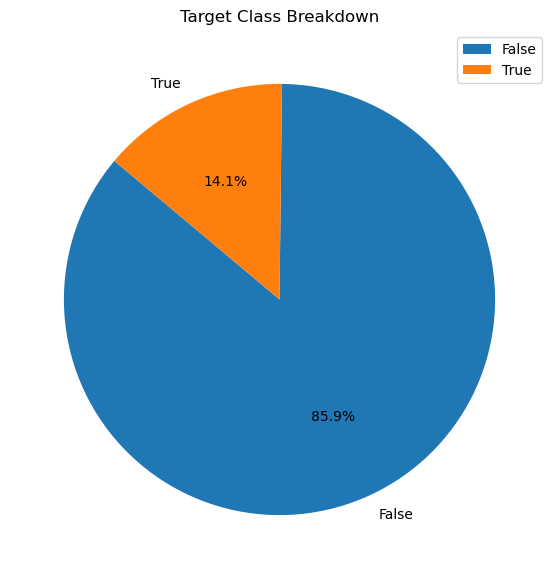

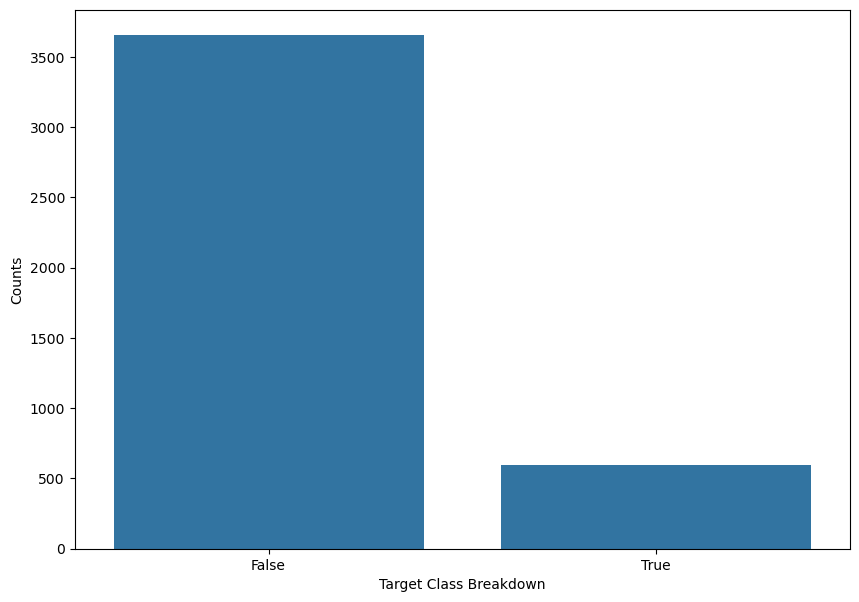

In [8]:
check_class_imbalance(df["churn"])

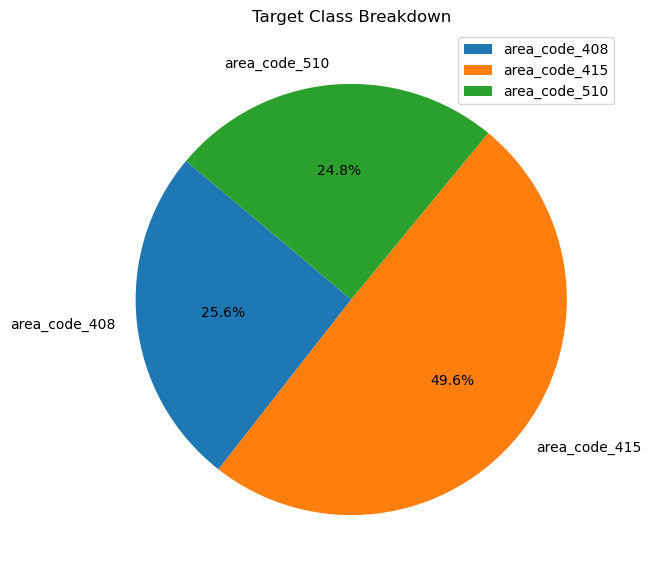

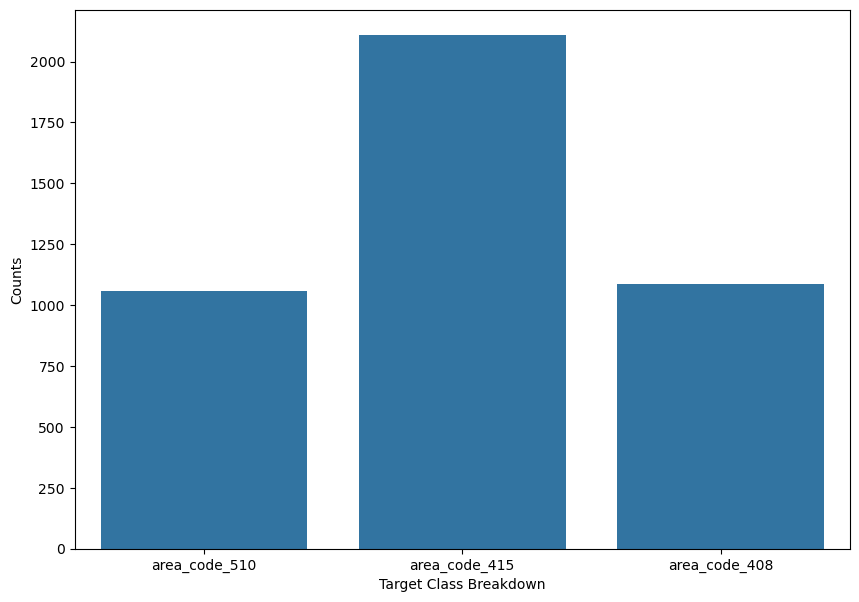

In [9]:
check_class_imbalance(df["area_code"])

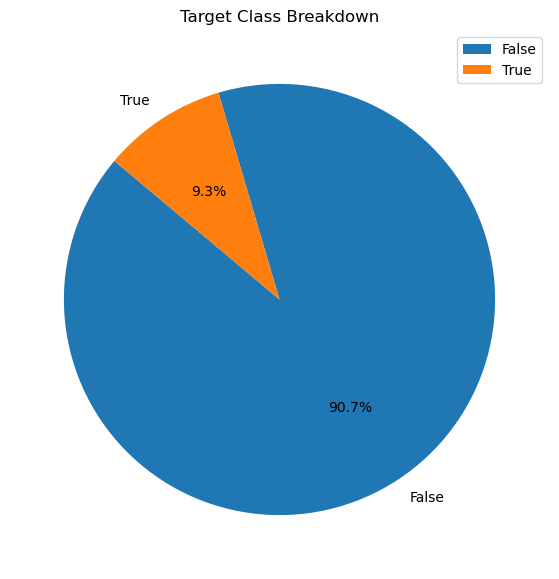

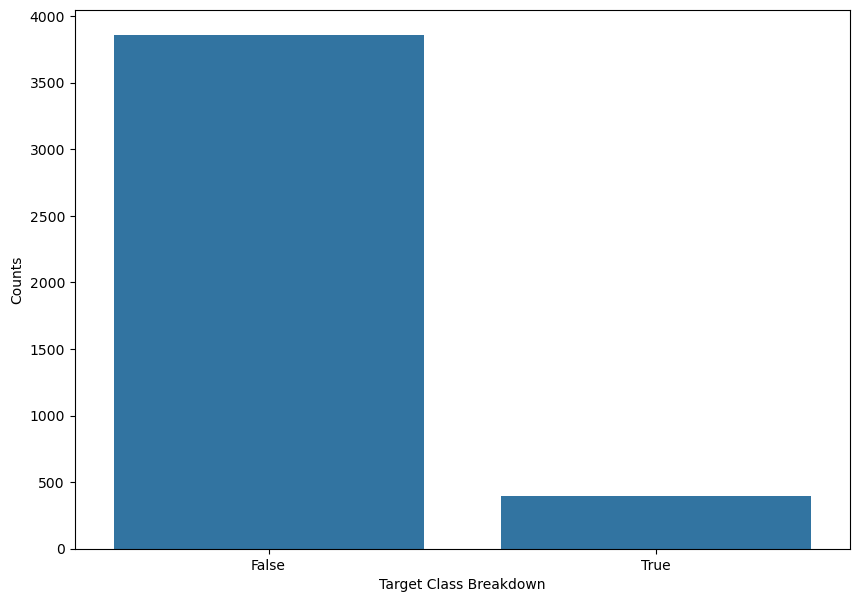

In [10]:
check_class_imbalance(df["international_plan"])

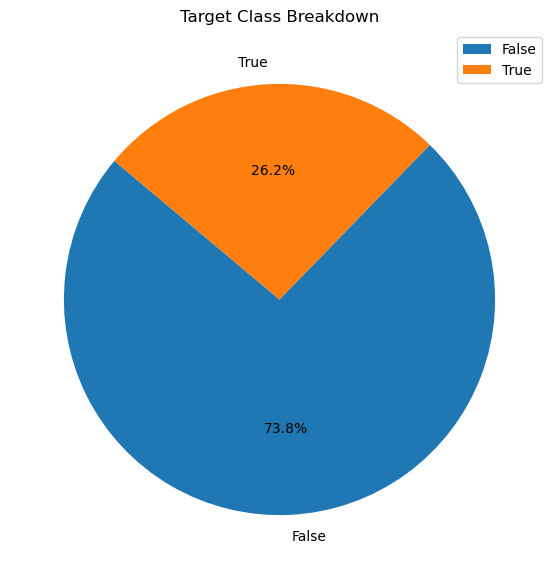

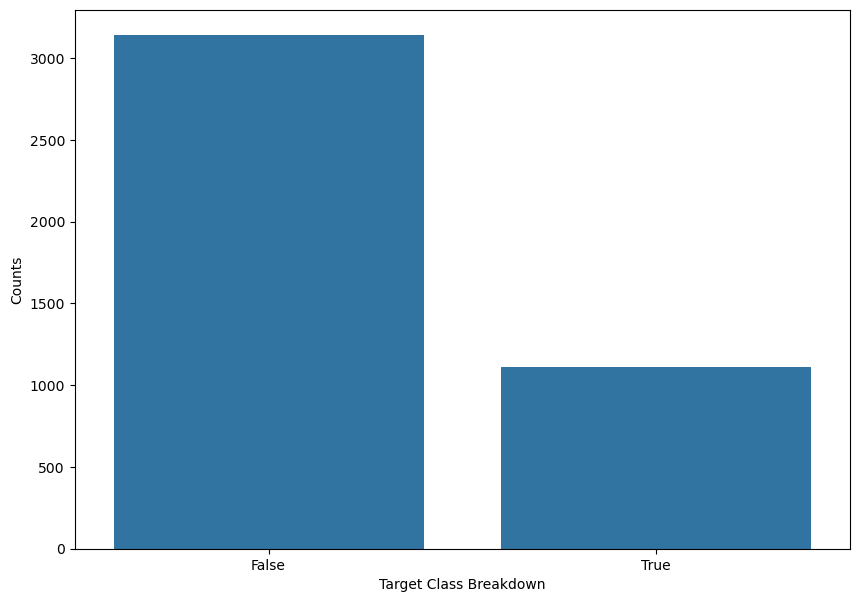

In [11]:
check_class_imbalance(df["voice_mail_plan"])

# Separate Categorical and Numerical Variables

In [12]:
categorical_types = df.select_dtypes(include="object")
numerical_types = df.select_dtypes(exclude="object")

# Visuals

<AxesSubplot:>

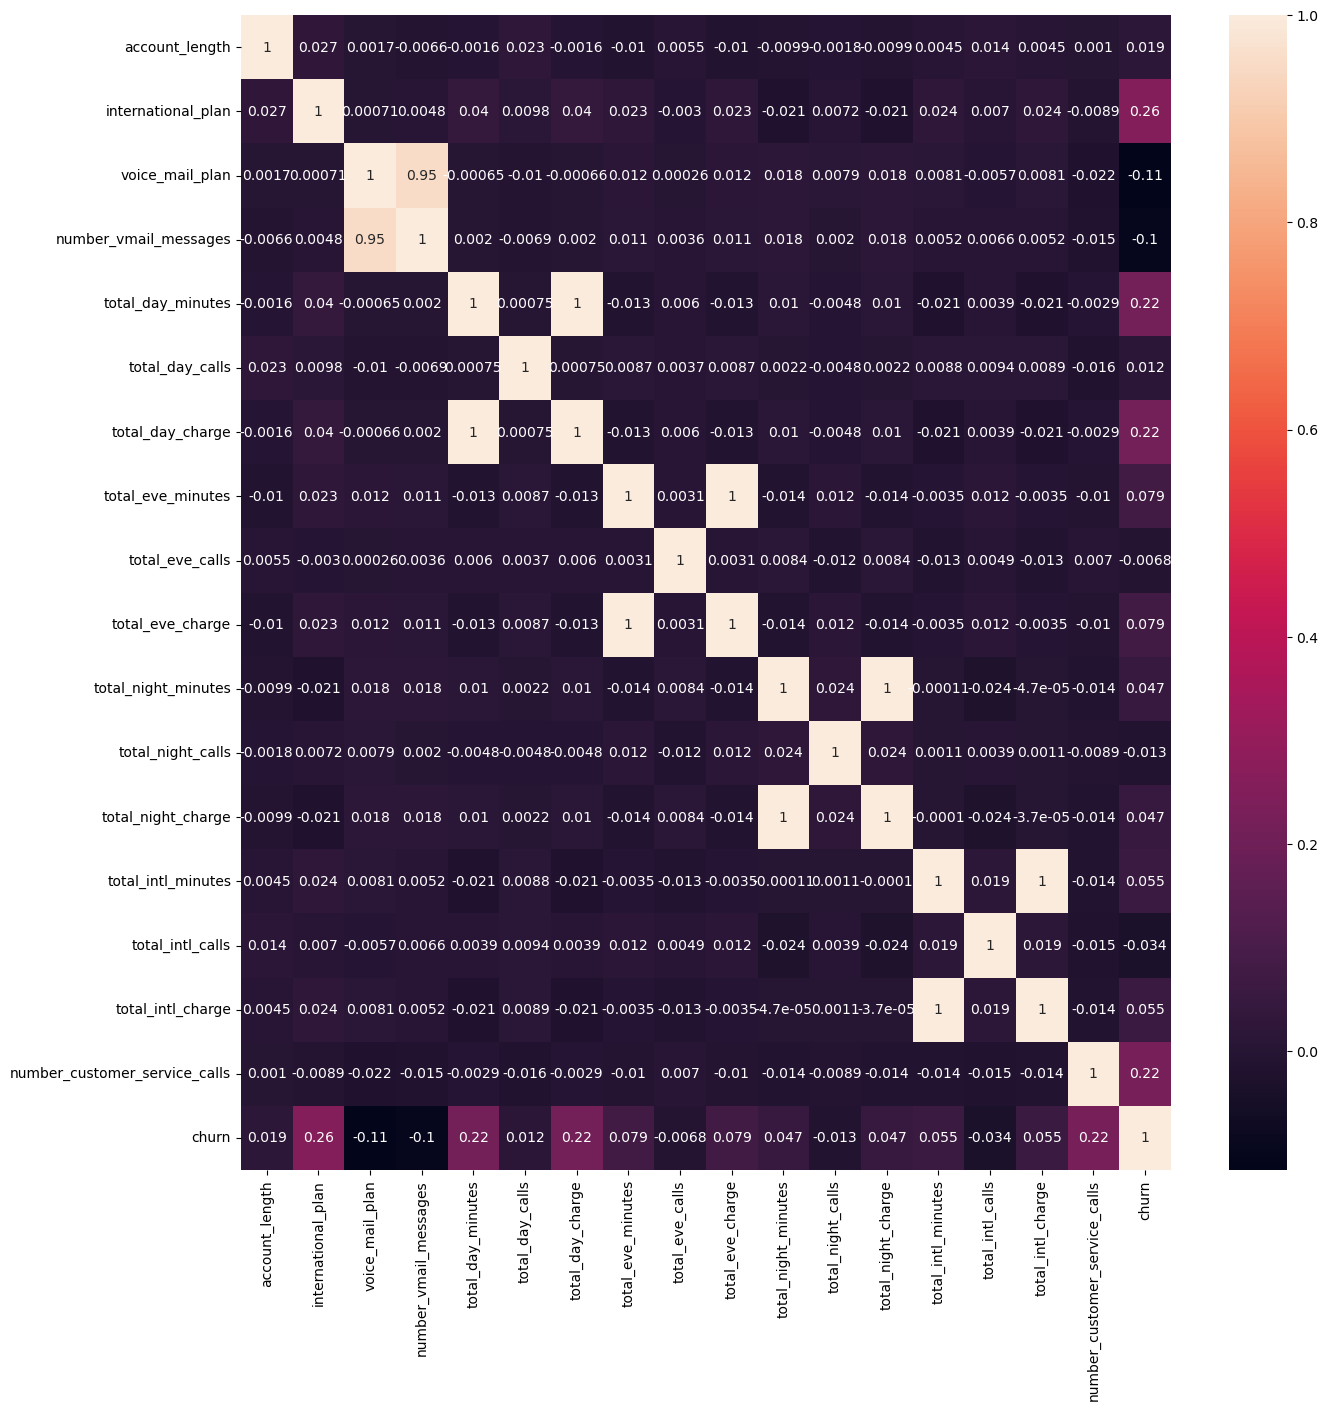

In [13]:
plt.figure(figsize=(15, 15))
relations = numerical_types.corr()
sns.heatmap(data=relations, annot=True)

# Histogram And Box Plots

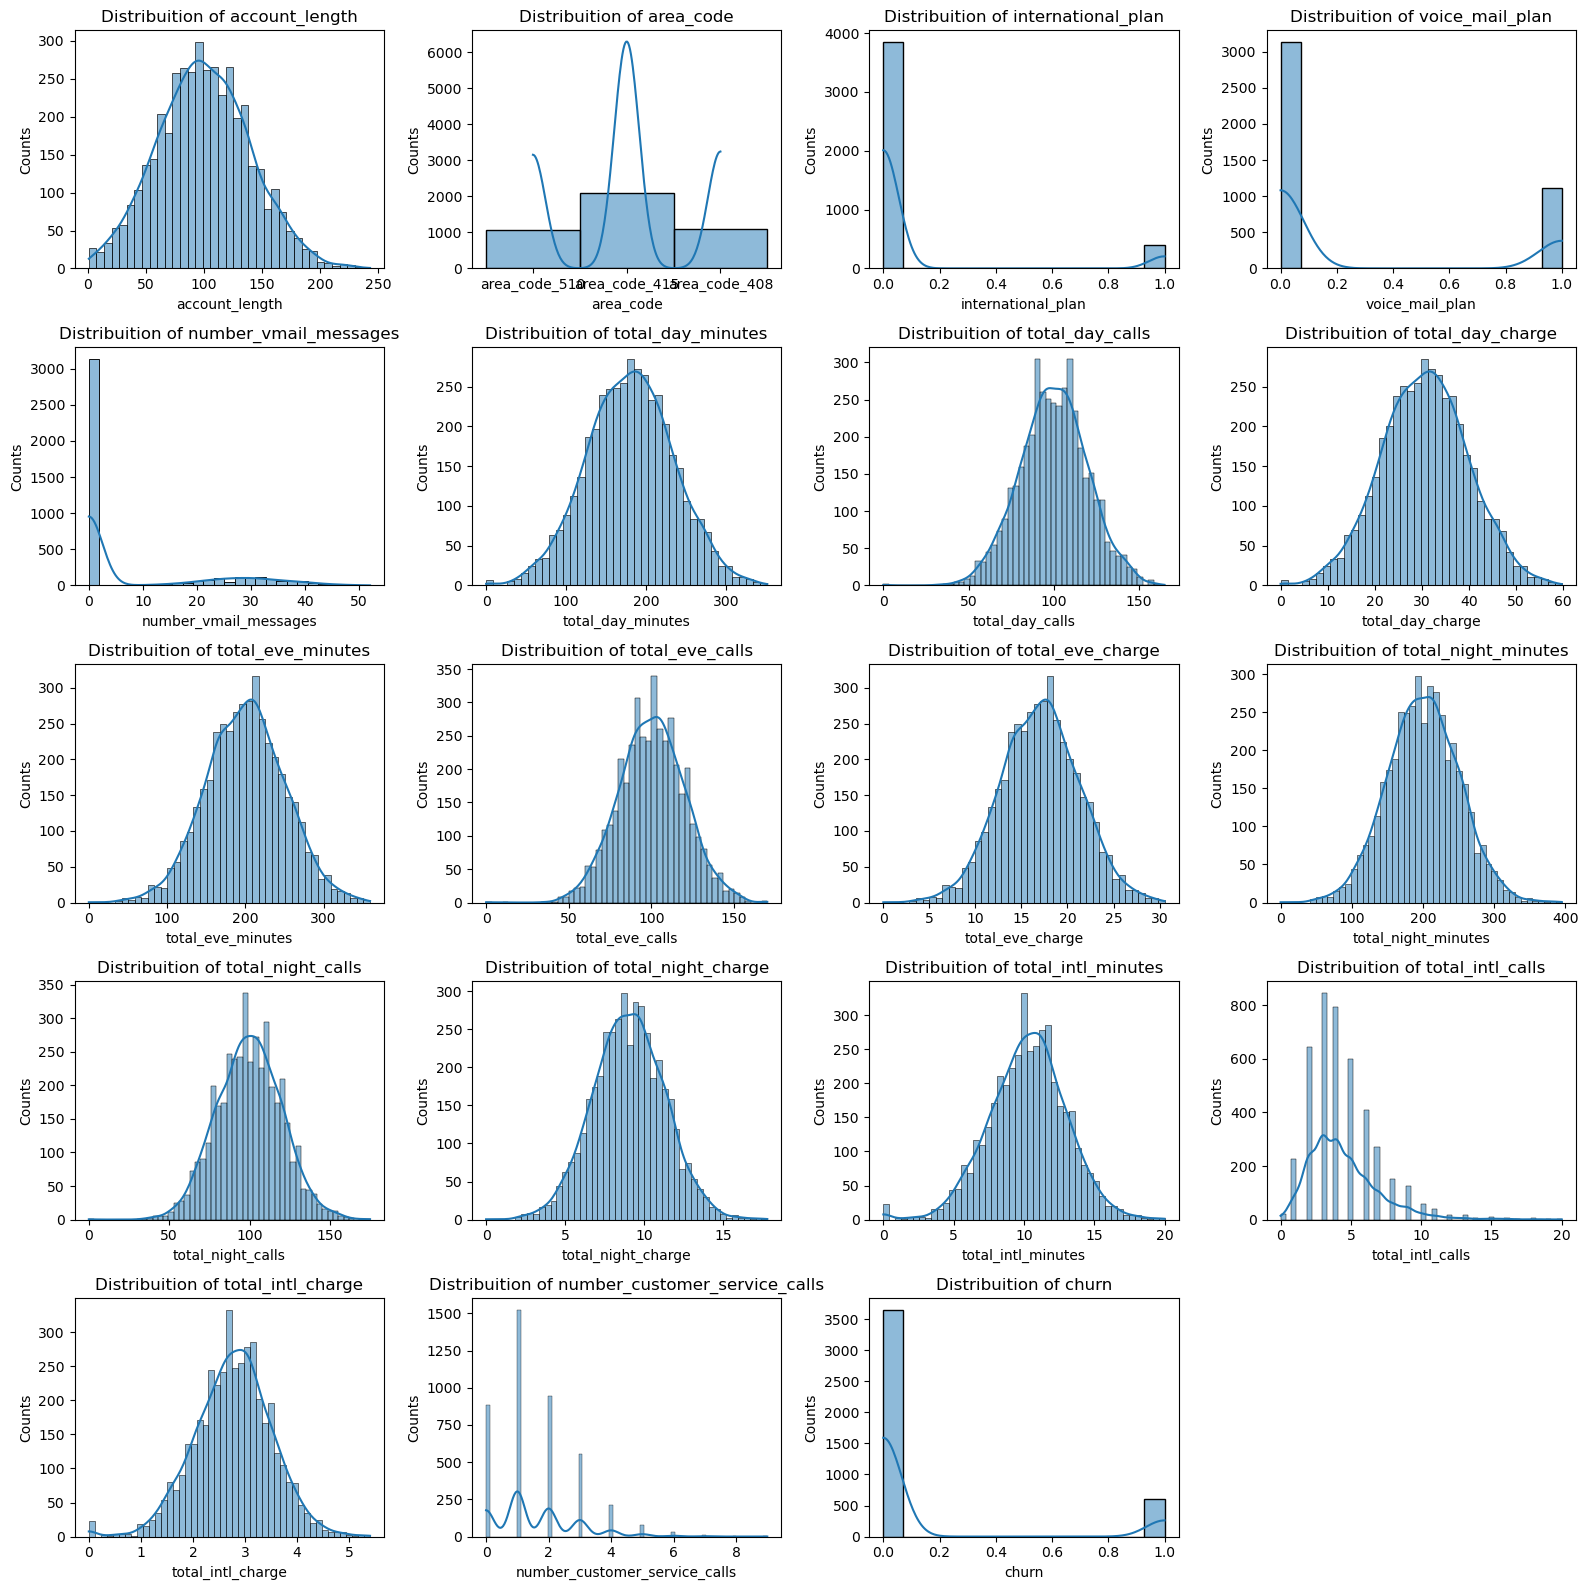

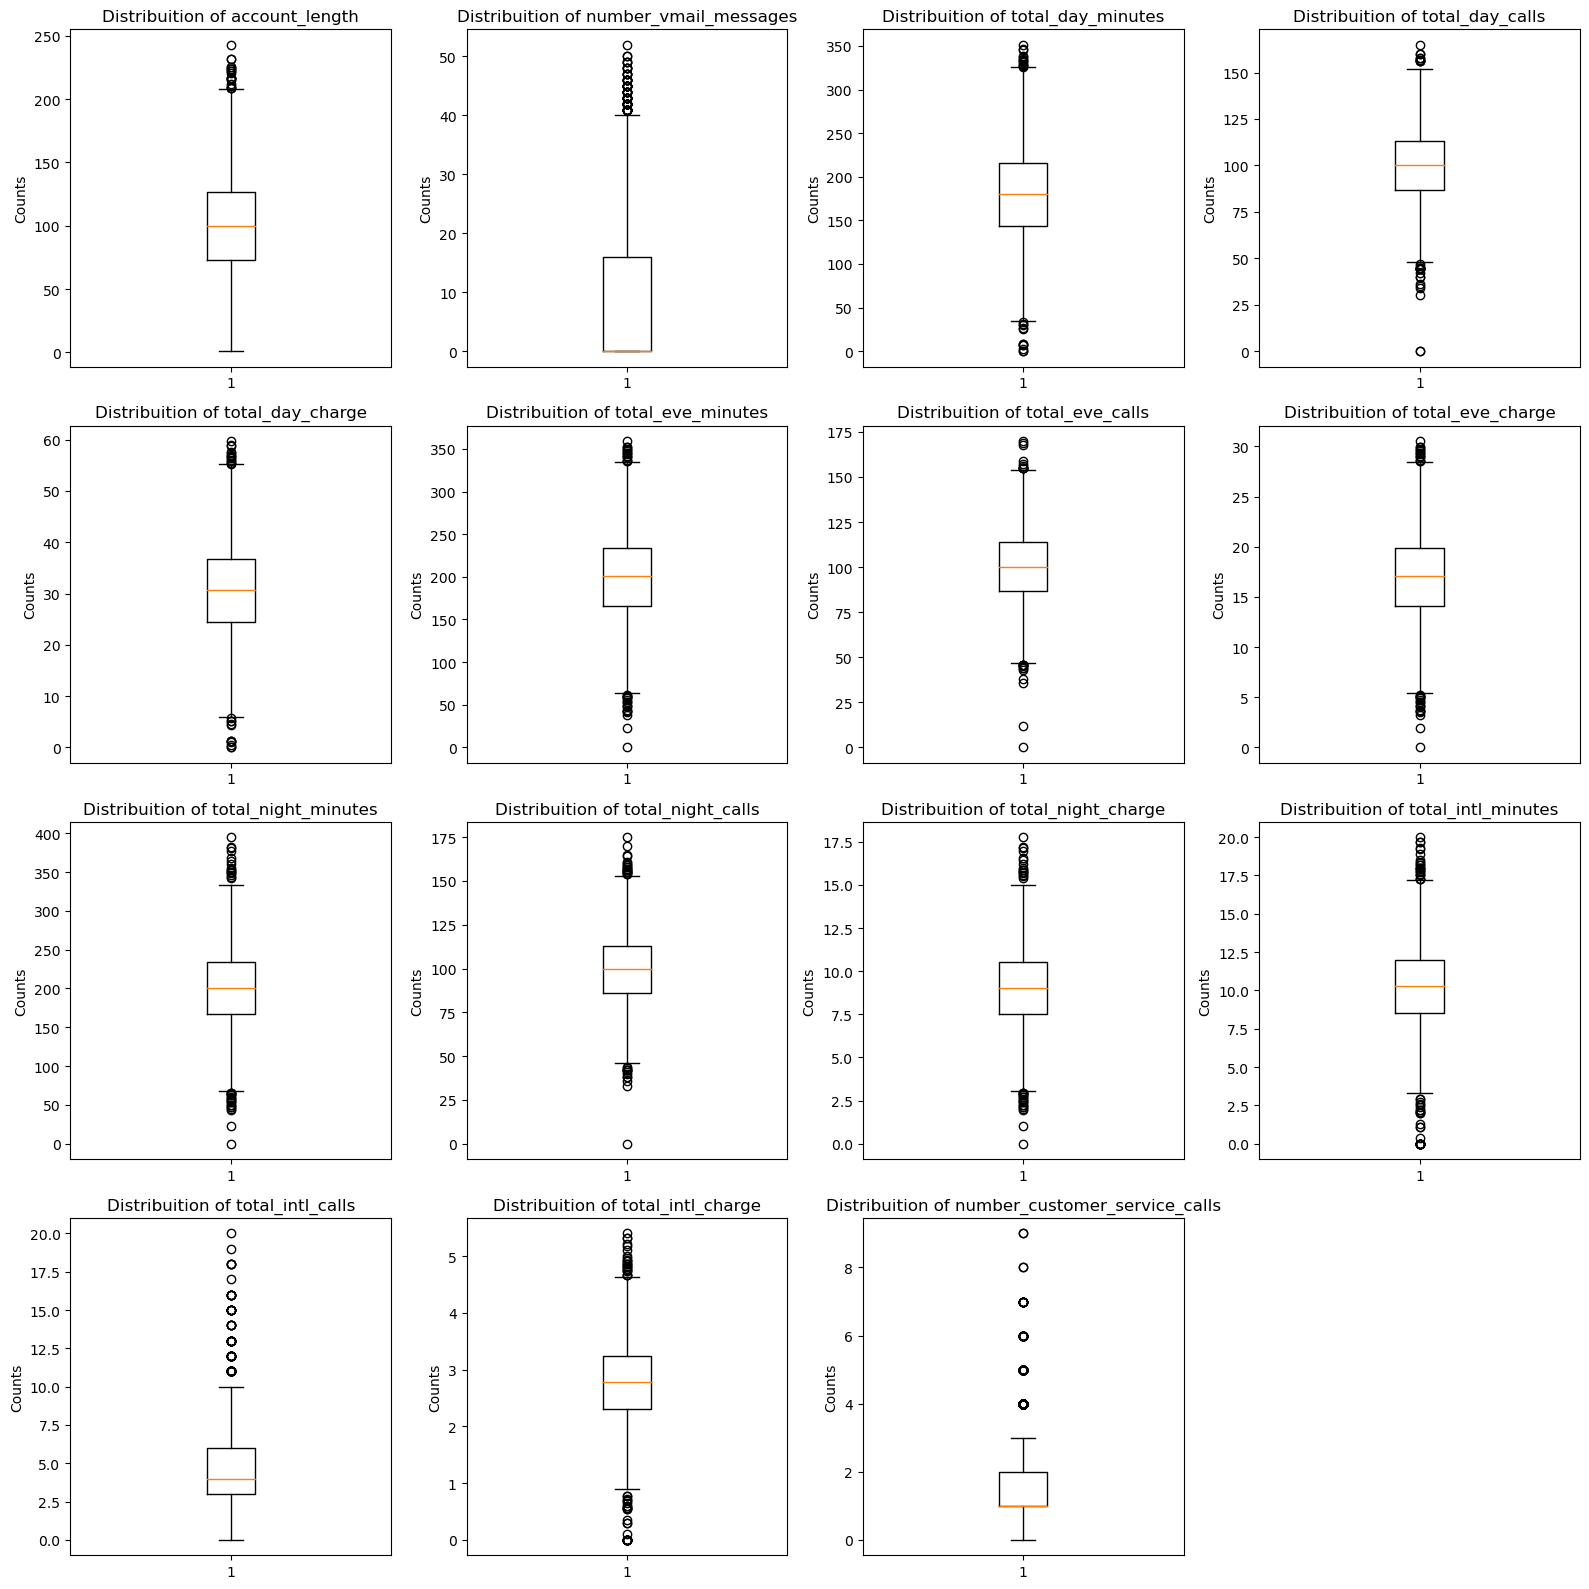

In [14]:
plot_distribution(df, "hist")
plot_distribution(df.select_dtypes(exclude=["object", "bool"]), "box")

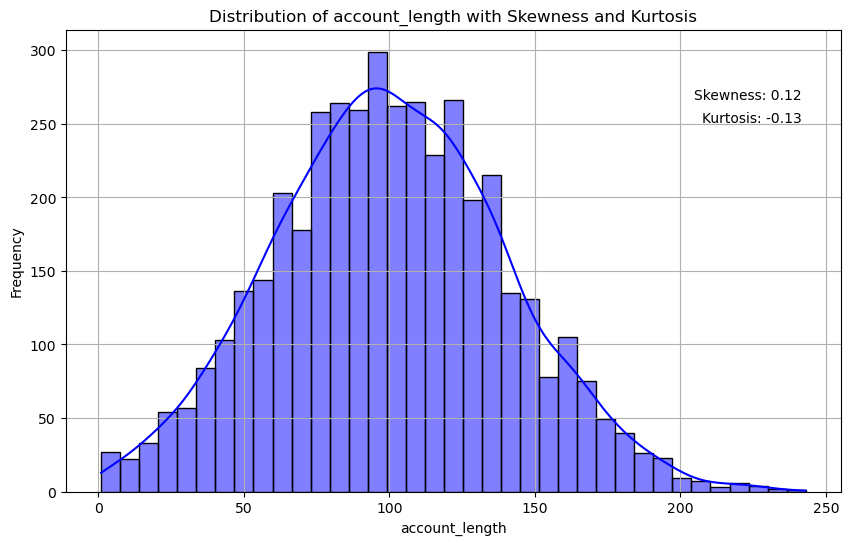

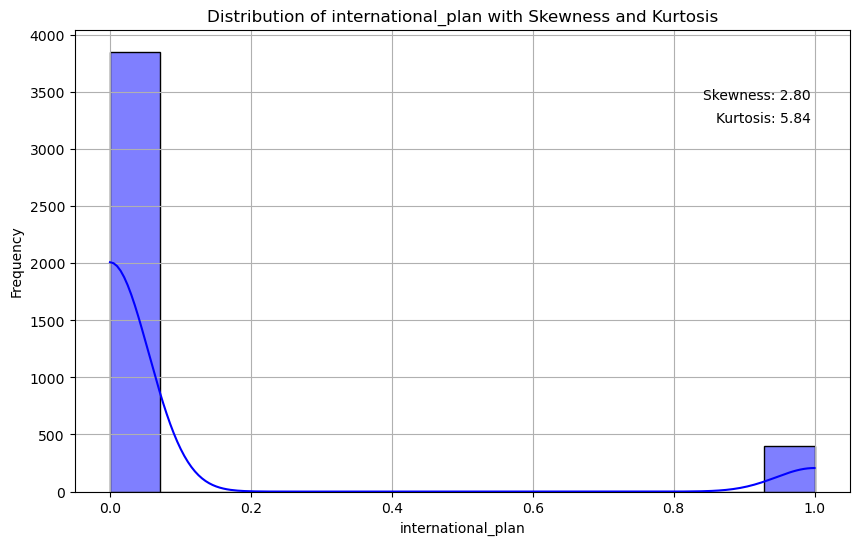

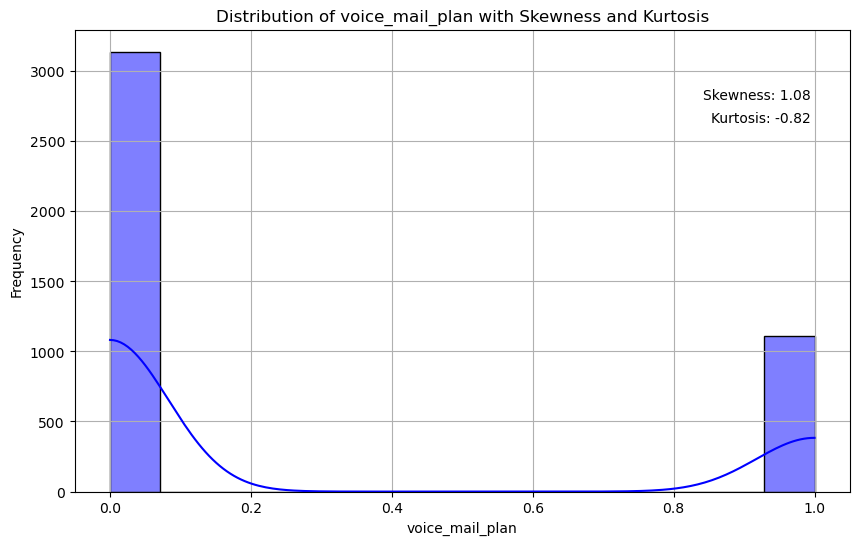

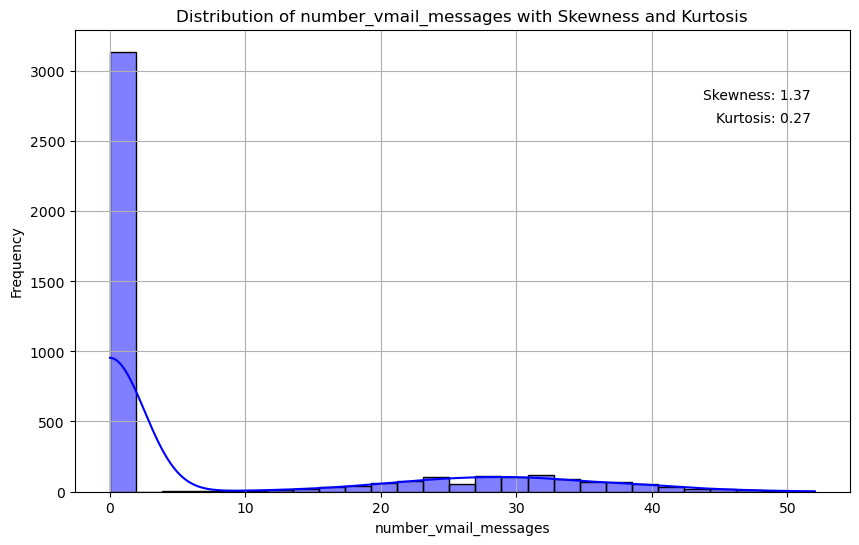

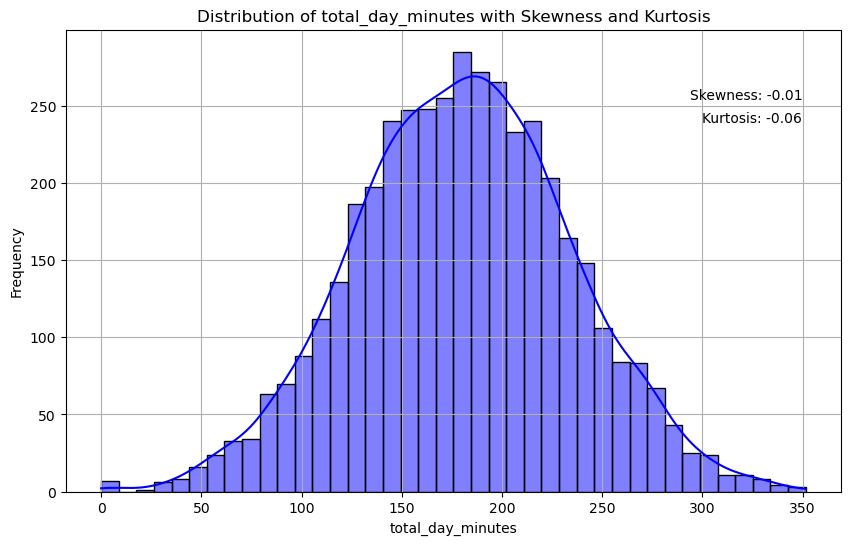

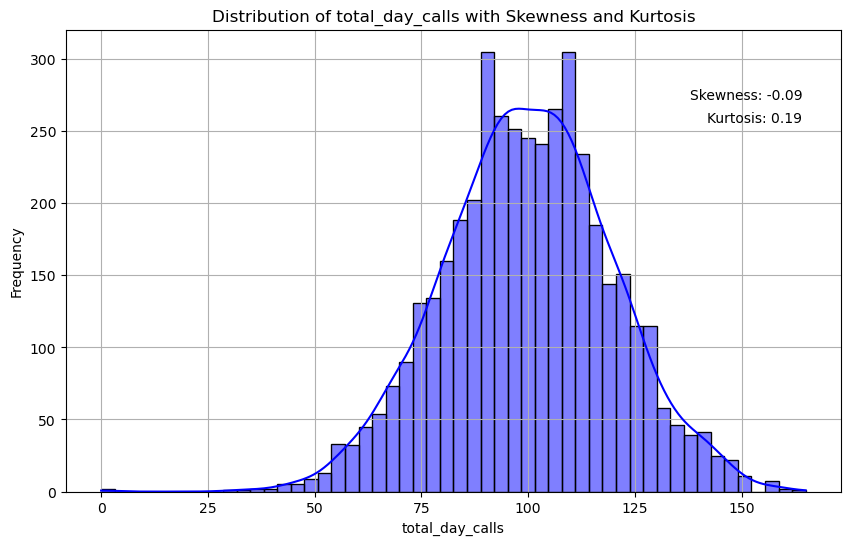

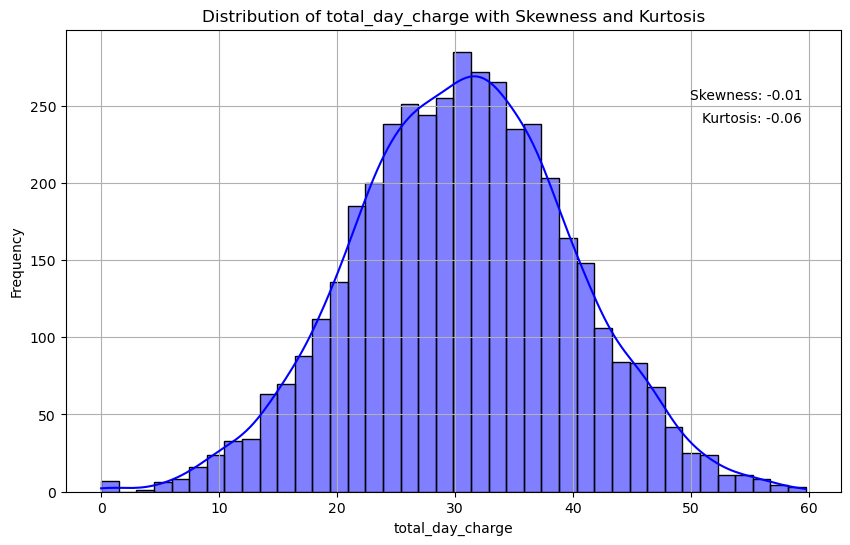

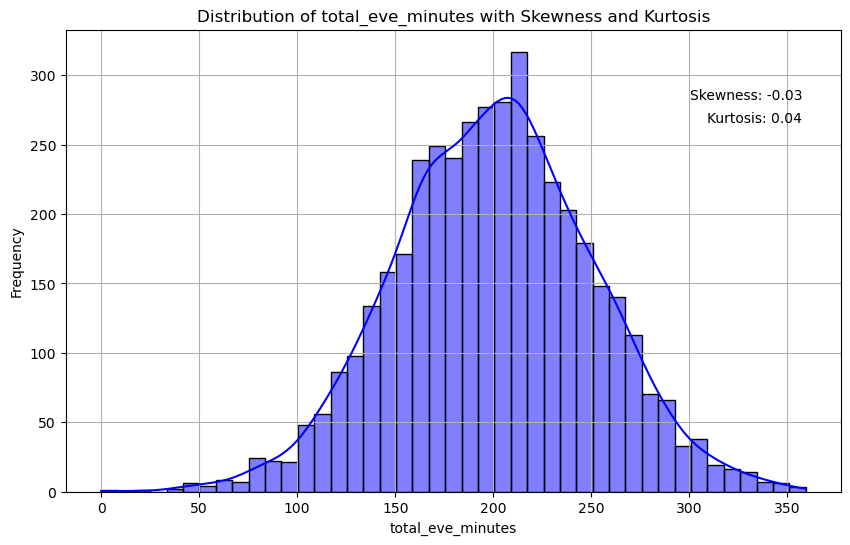

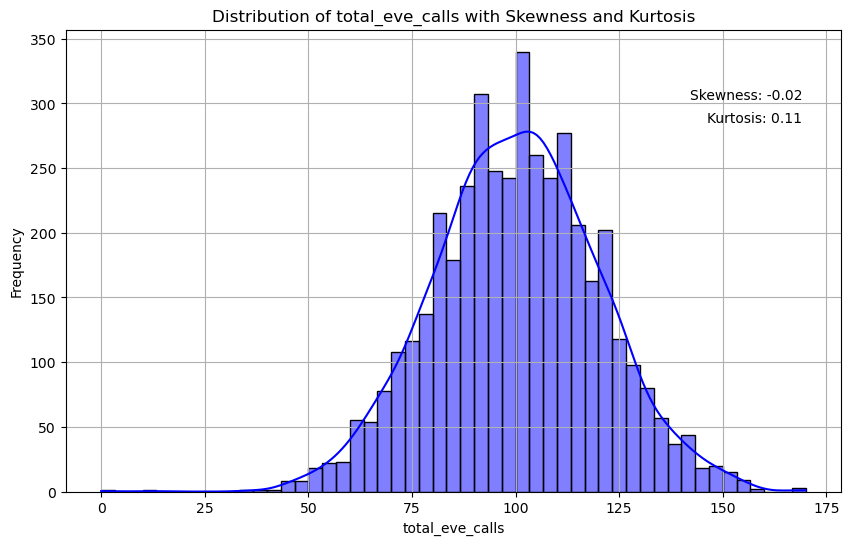

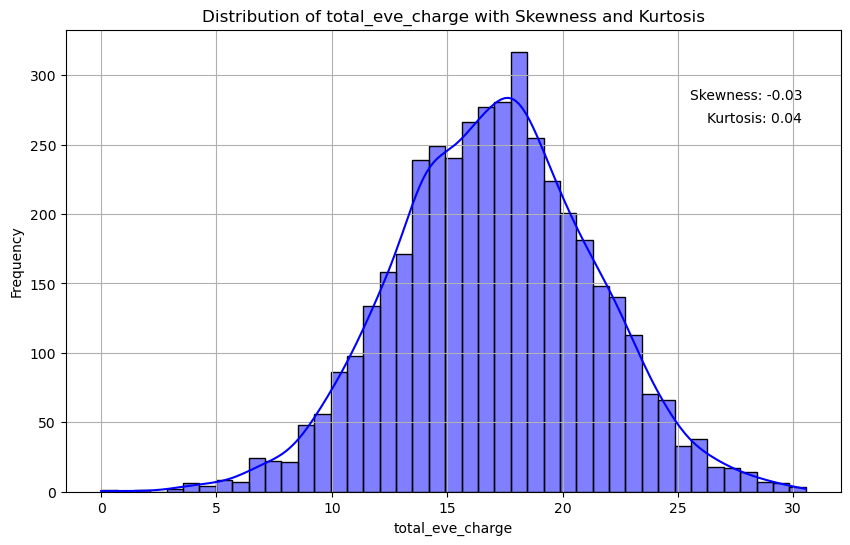

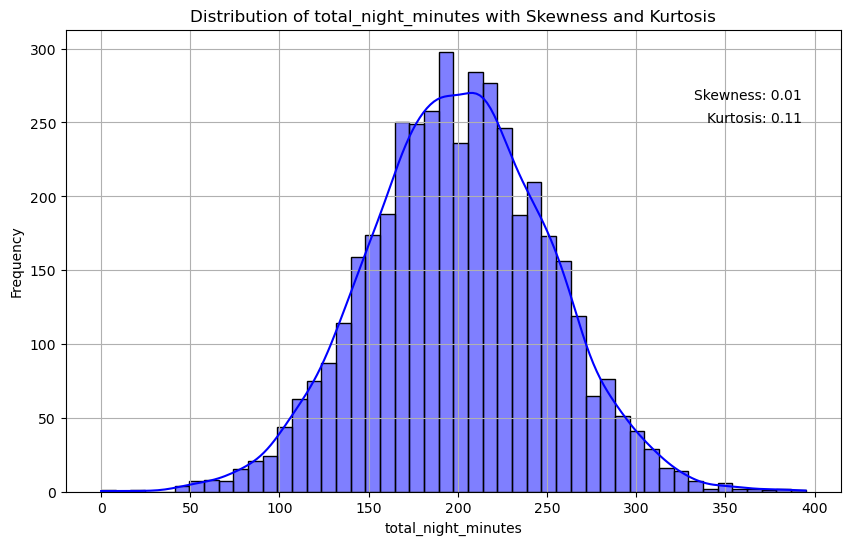

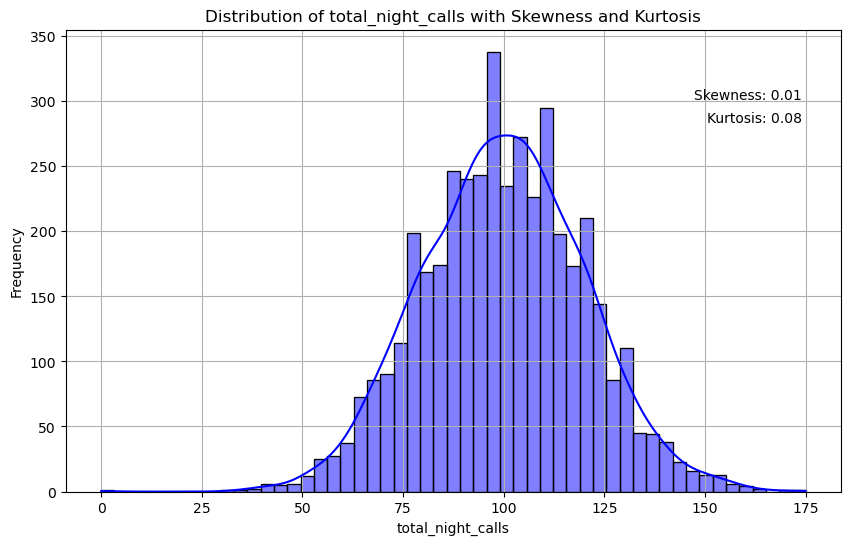

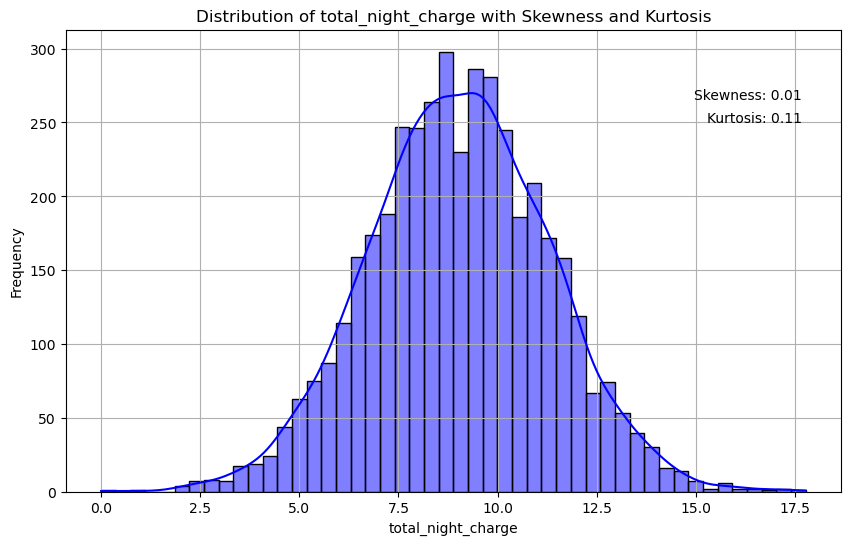

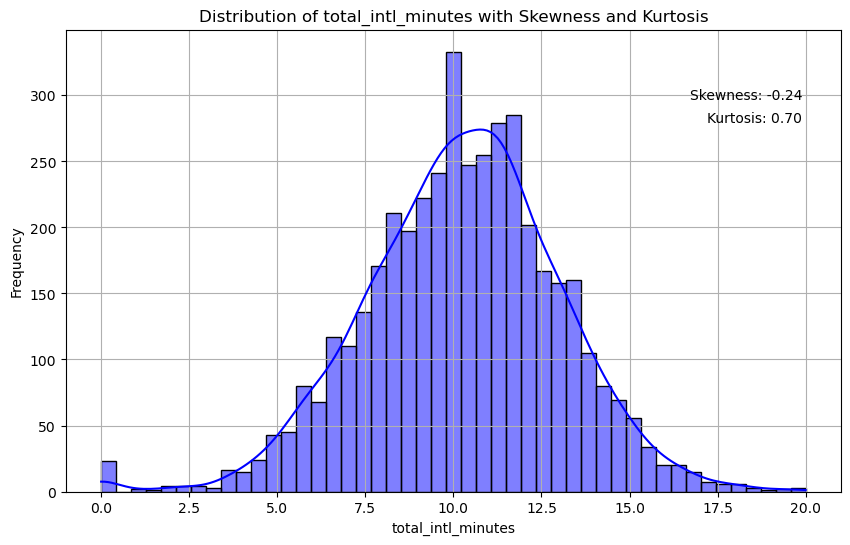

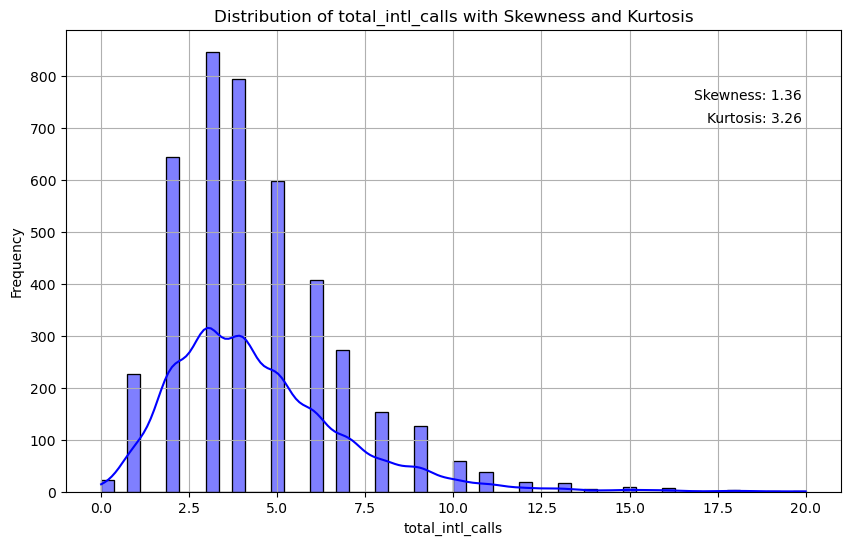

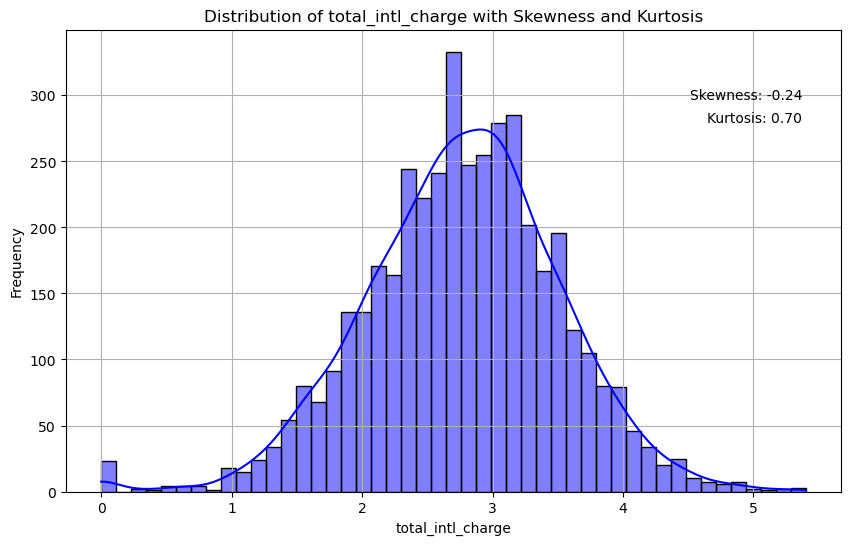

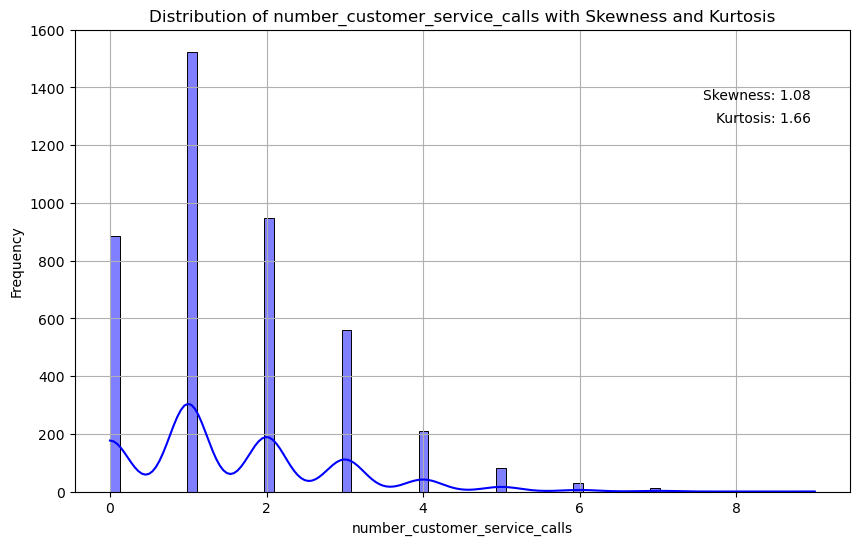

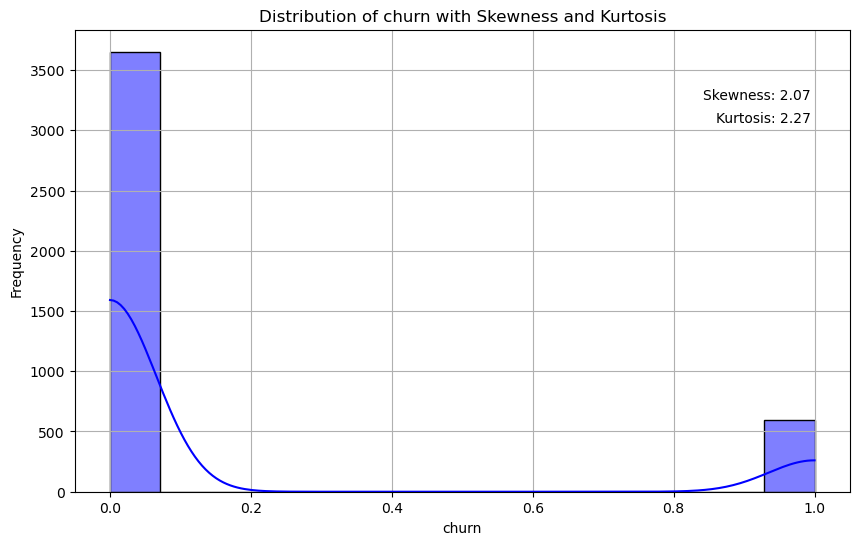

In [16]:
dist_plot(numerical_types)

# Aggregated Views

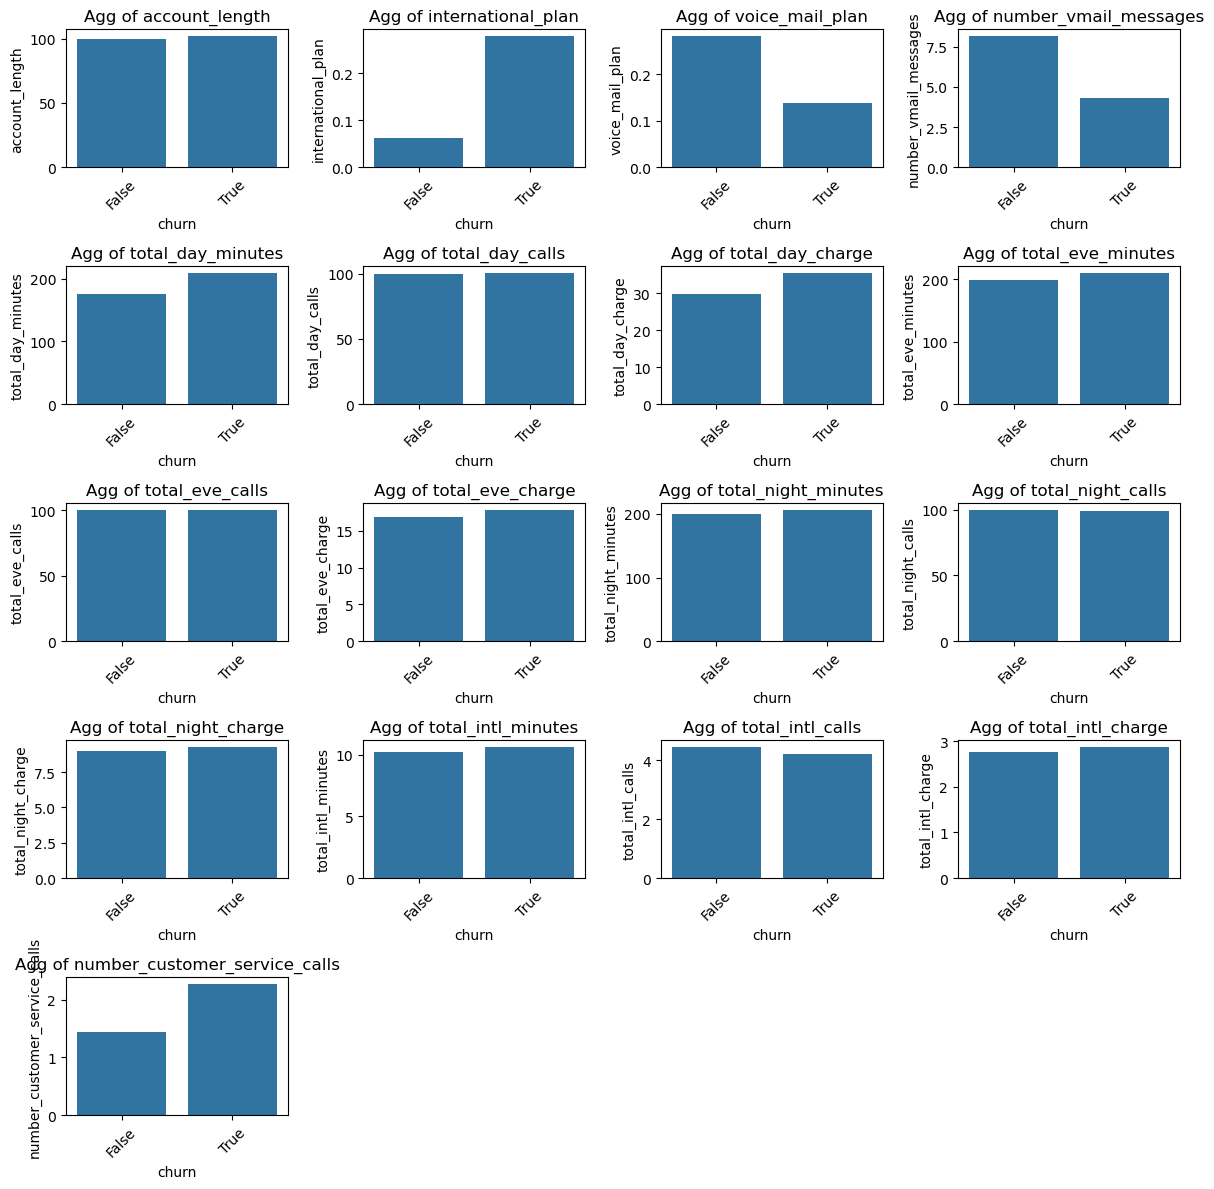

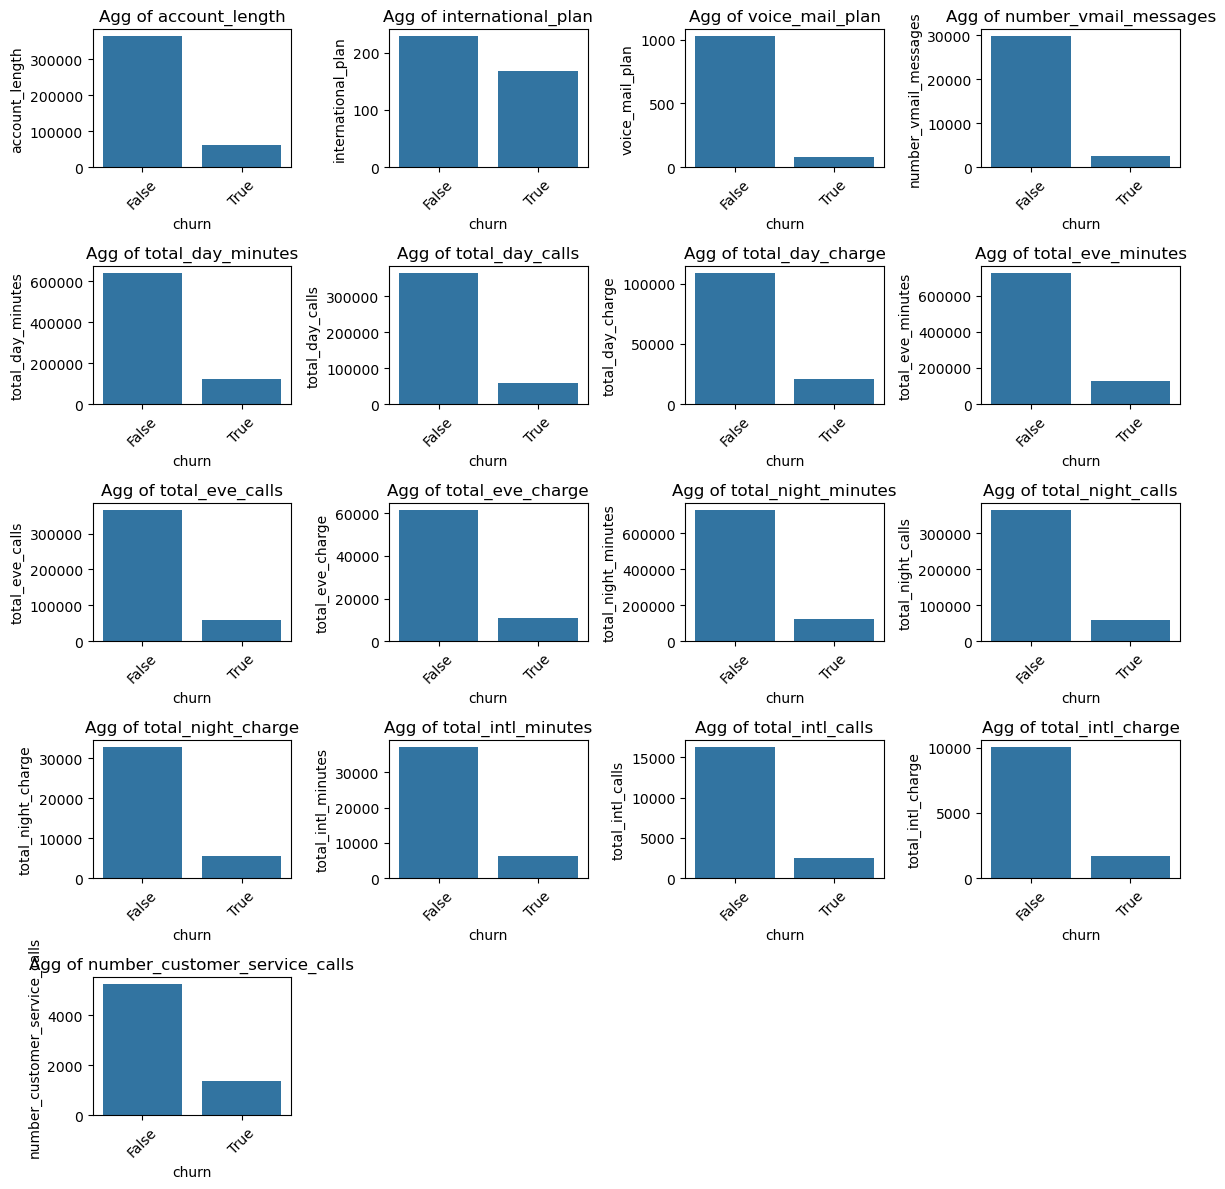

In [19]:
aggregate_dataset(df, numerical_types.columns, "churn", "mean")
aggregate_dataset(df, numerical_types.columns, "churn", "sum")

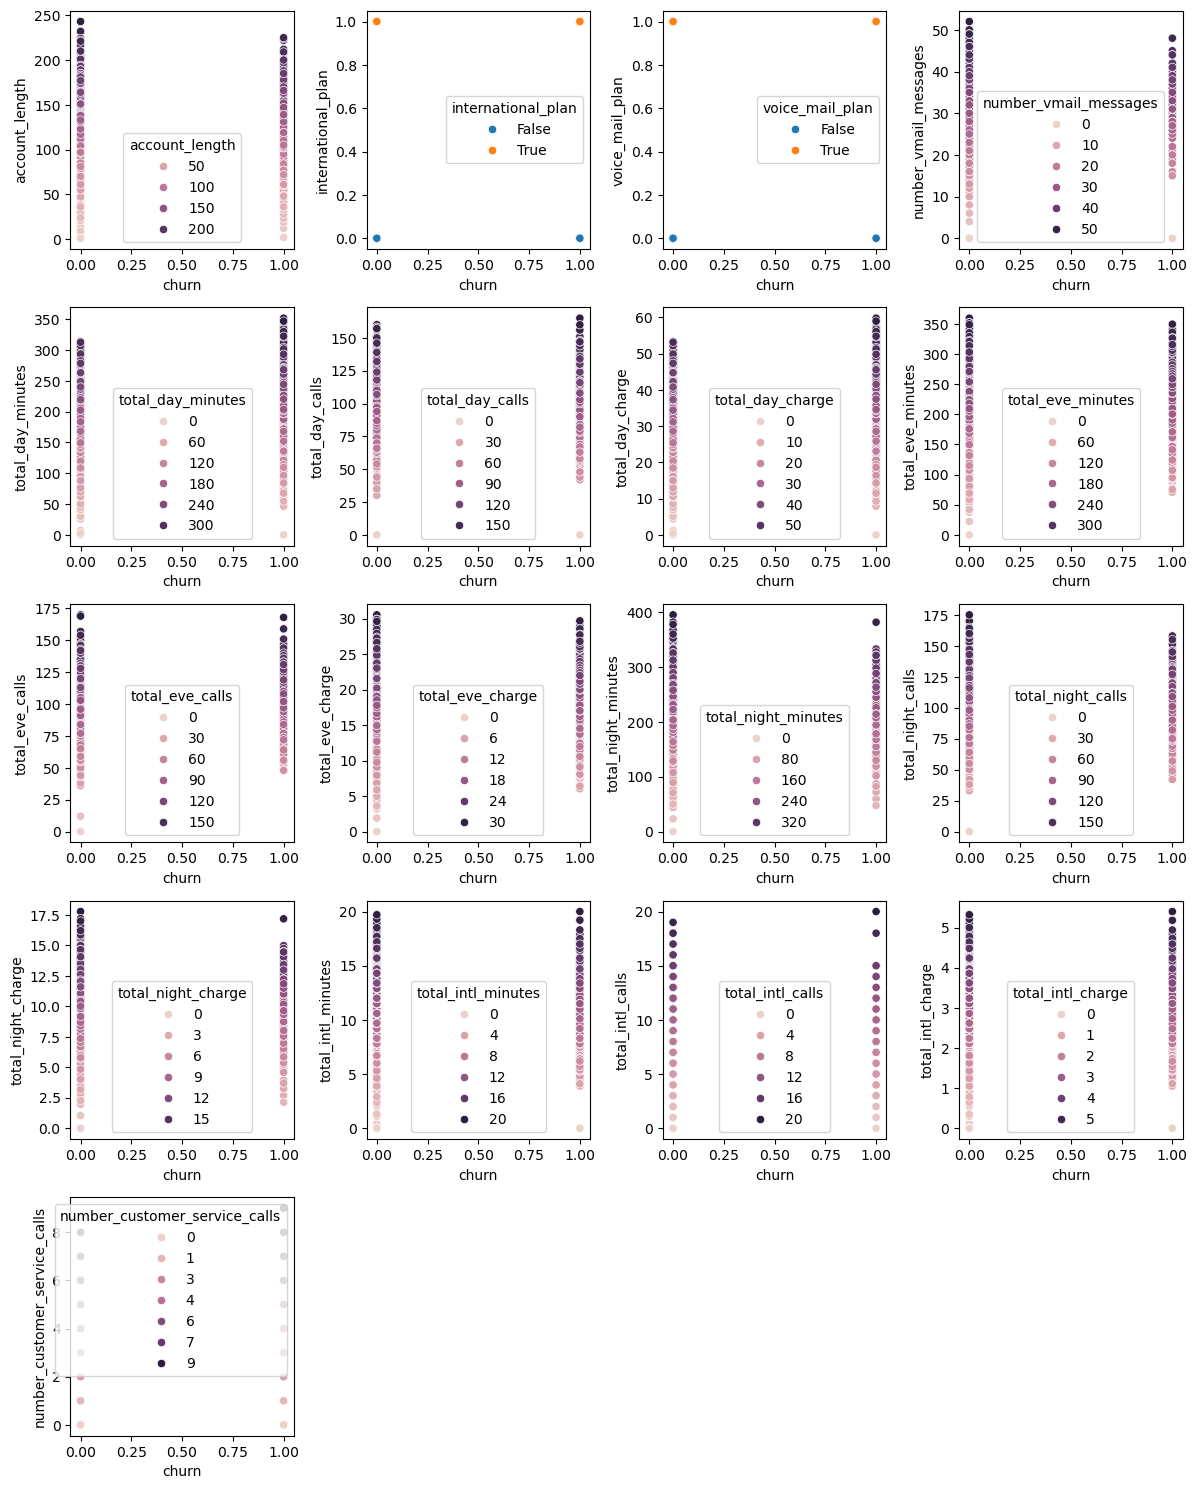

In [21]:
scatter_plot(df, numerical_types.columns, "churn")

# Create Preprocessor

In [26]:
numerical_types.drop(columns=["churn", "international_plan", "voice_mail_plan"], inplace=True)

In [28]:
preprocessor = create_column_transformer(
  ["area_code", "international_plan", "voice_mail_plan"], 
  numerical_types.columns
  )
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['area_code', 'international_plan',
                                  'voice_mail_plan']),
                                ('numeric',
                                 Pipeline(steps=[('scaler', RobustScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls'],
      dtype='object'))])

# Separate Features

In [34]:
X = df.drop("churn", axis=1)
y = df["churn"]

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# PCA Analysis

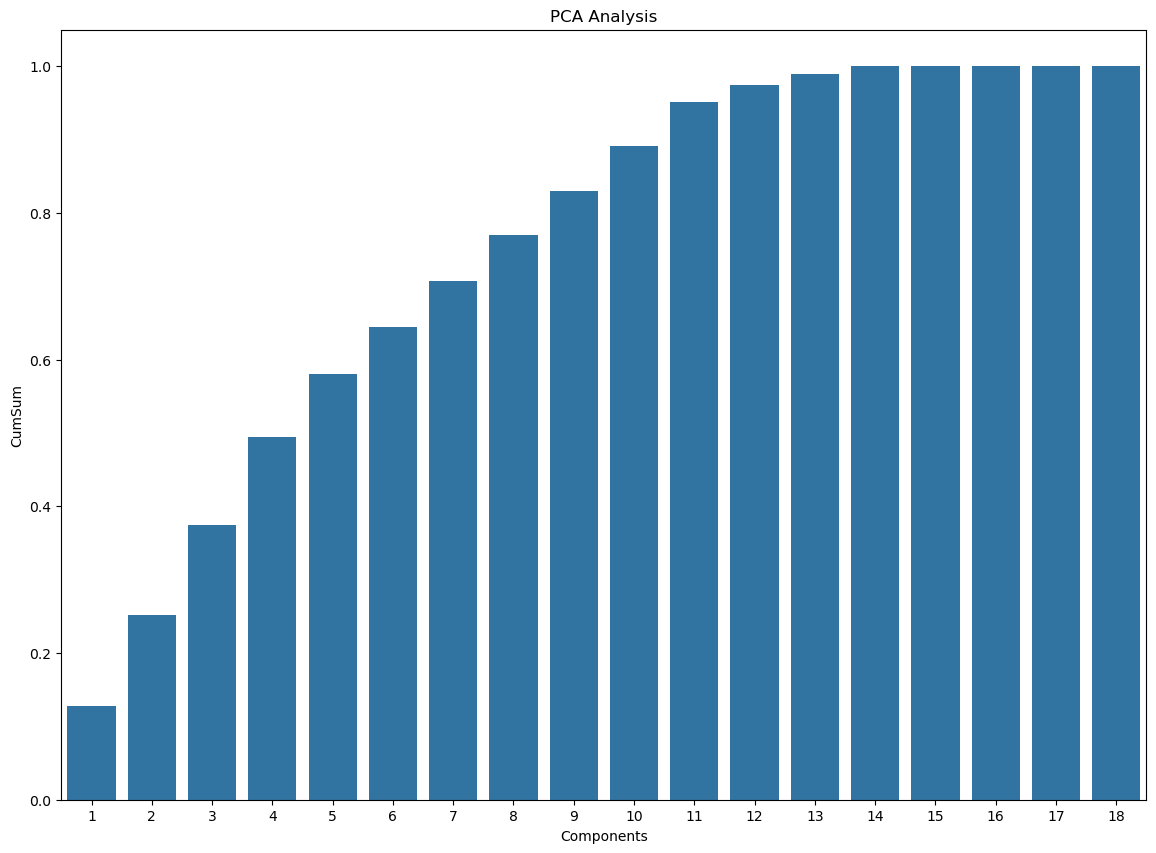

,Component,CumSum
0,1,0.127305
1,2,0.252358
2,3,0.374600
3,4,0.495159
4,5,0.580742
5,6,0.645252
6,7,0.707849
7,8,0.769605
8,9,0.830483
9,10,0.891108


In [30]:
pca_analysis(X, preprocessor)

# Base Model

In [31]:
df

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,86,area_code_510,False,False,0,70.7,125,12.02,211.0,113,17.94,174.6,107,7.86,0.0,0,0.00,2,False
1,165,area_code_510,False,False,0,242.9,126,41.29,209.8,65,17.83,228.4,126,10.28,0.0,0,0.00,1,False
2,70,area_code_415,False,False,0,222.8,114,37.88,215.9,113,18.35,223.5,122,10.06,0.0,0,0.00,1,False
3,158,area_code_408,False,False,0,172.4,114,29.31,256.6,69,21.81,235.3,104,10.59,0.0,0,0.00,2,False
4,101,area_code_415,False,False,0,217.7,118,37.01,231.7,128,19.69,185.3,128,8.34,0.0,0,0.00,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,36,area_code_415,False,True,16,149.4,111,25.40,131.8,113,11.20,132.7,87,5.97,6.7,2,1.81,0,False
4246,24,area_code_510,False,True,25,164.9,110,28.03,209.3,105,17.79,231.2,55,10.40,6.7,9,1.81,1,False
4247,97,area_code_415,False,True,32,183.4,94,31.18,269.1,120,22.87,203.5,38,9.16,6.7,4,1.81,5,False
4248,81,area_code_408,False,True,46,168.3,124,28.61,270.9,103,23.03,222.5,98,10.01,6.7,2,1.81,4,False


# Create Metrics

In [33]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="weighted")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='weighted')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='weighted')

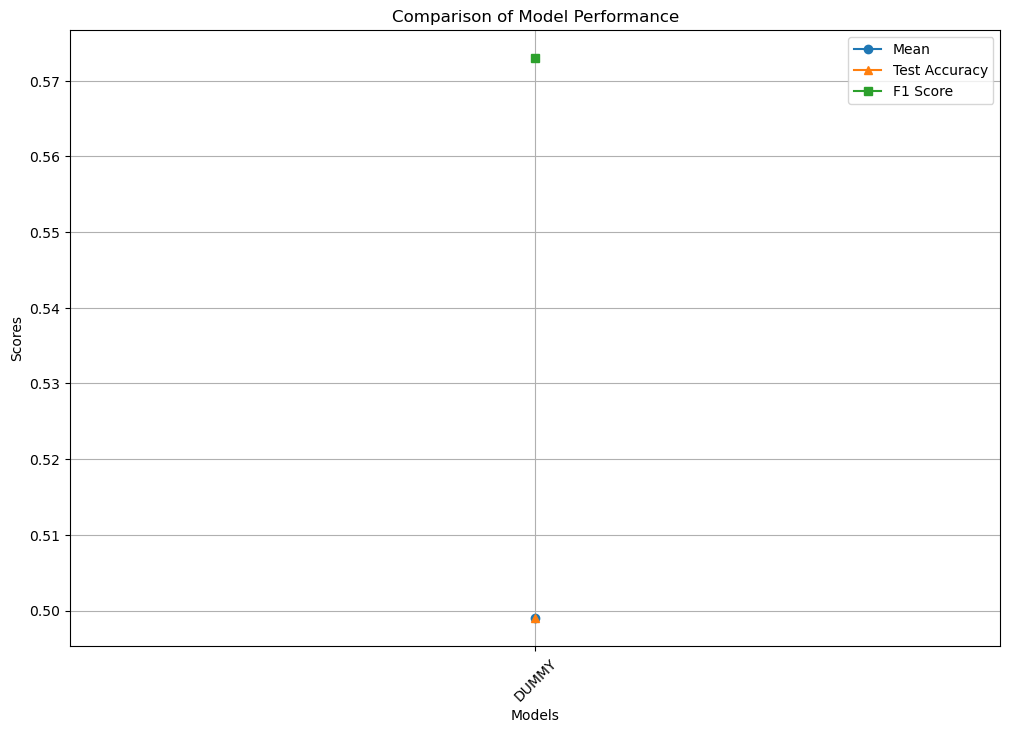

,Model,Mean,Var,STD,Test-Acc,recall-Score,precision-Score,F1-Score
0,DUMMY,0.499,0.001,0.025,0.499,0.499,0.753,0.573


In [35]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
test_selected_models(preprocessor,model_name, models, X, y_encoded, acc_metric)

# Test K-Best Columns

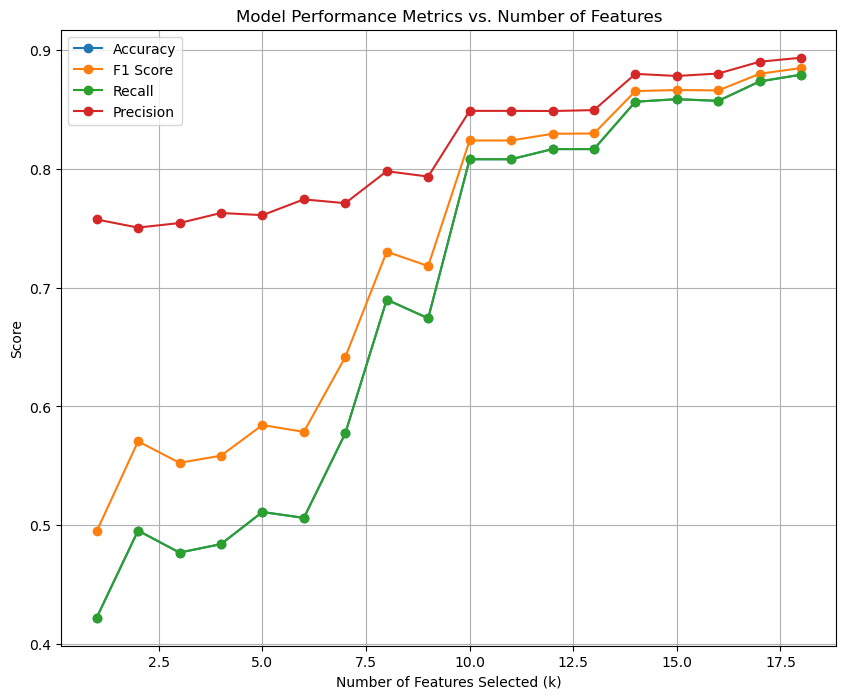

,Model,K,Selected Featured,acc_metric,f1_metric,recall,precision
0,SVC,1,total_night_calls,0.421953,0.494674,0.421953,0.757515
1,SVC,2,"total_day_calls, total_night_calls",0.495367,0.570585,0.495367,0.750693
2,SVC,3,"total_day_calls, total_eve_calls, total_night_...",0.476835,0.552490,0.476835,0.754499
3,SVC,4,"total_day_calls, total_eve_calls, total_night_...",0.483963,0.558462,0.483963,0.763000
4,SVC,5,"total_day_calls, total_eve_calls, total_night_...",0.511048,0.584305,0.511048,0.761153
5,SVC,6,"account_length, total_day_calls, total_eve_cal...",0.506058,0.578537,0.506058,0.774452
6,SVC,7,"account_length, total_day_calls, total_eve_cal...",0.577334,0.641584,0.577334,0.771249
7,SVC,8,"account_length, total_day_calls, total_eve_cal...",0.689950,0.730351,0.689950,0.798193
8,SVC,9,"area_code_area_code_415, account_length, total...",0.674269,0.718300,0.674269,0.793681
9,SVC,10,"area_code_area_code_415, account_length, total...",0.808268,0.824077,0.808268,0.849035


In [42]:
model_name = ["SVC"]
models = grab_selected_models(model_name)[0]
metric = mutual_info_classif
sample_model = SMOTE()
test_kbest_columns(preprocessor, X, y_encoded, sample_model, models, model_name[0], metric)

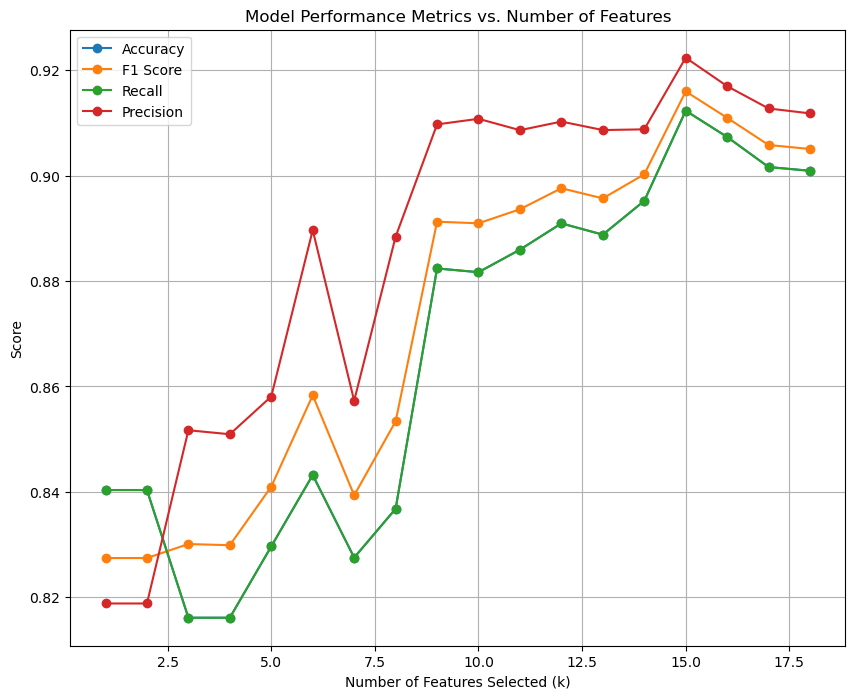

,Model,K,Selected Featured,acc_metric,f1_metric,recall,precision
0,SVC,1,international_plan_False,0.840342,0.827435,0.840342,0.818811
1,SVC,2,"international_plan_False, international_plan_True",0.840342,0.827435,0.840342,0.818811
2,SVC,3,"international_plan_False, international_plan_T...",0.816108,0.830091,0.816108,0.851690
3,SVC,4,"international_plan_False, international_plan_T...",0.816108,0.829868,0.816108,0.850930
4,SVC,5,"international_plan_False, international_plan_T...",0.829651,0.840992,0.829651,0.858092
5,SVC,6,"international_plan_False, international_plan_T...",0.843193,0.858329,0.843193,0.889669
6,SVC,7,"international_plan_False, international_plan_T...",0.827512,0.839334,0.827512,0.857289
7,SVC,8,"international_plan_False, international_plan_T...",0.836778,0.853367,0.836778,0.888414
8,SVC,9,"international_plan_False, international_plan_T...",0.882395,0.891266,0.882395,0.909737
9,SVC,10,"international_plan_False, international_plan_T...",0.881682,0.890960,0.881682,0.910794


In [43]:
metric = f_classif
test_kbest_columns(preprocessor, X, y_encoded, sample_model, models, model_name[0], metric)

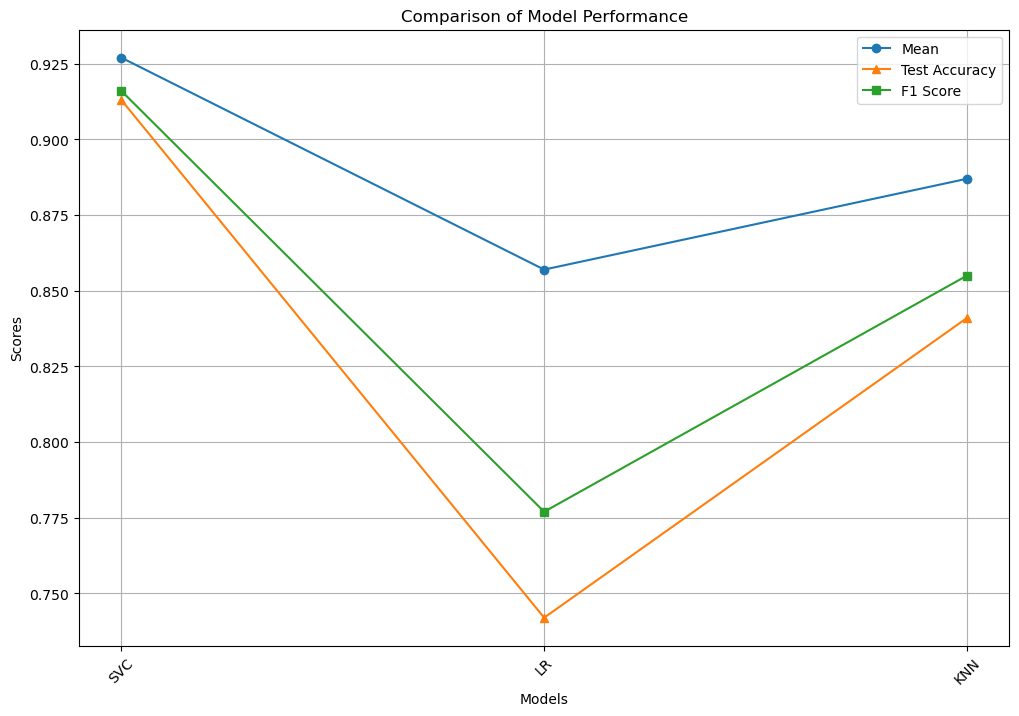

,Model,Mean,Var,STD,Test-Acc,recall-Score,precision-Score,F1-Score
0,SVC,0.927,0.0,0.010,0.913,0.913,0.919,0.916
2,KNN,0.887,0.0,0.010,0.841,0.841,0.880,0.855
1,LR,0.857,0.0,0.011,0.742,0.742,0.854,0.777


In [44]:
kbest = SelectKBest(score_func=f_classif, k=15)
model_names = ["SVC", "LR", "KNN"]
models = grab_selected_models(model_names)
test_selected_models(preprocessor,model_names, models, X, y_encoded, precision_metric, sample_model, kbest)

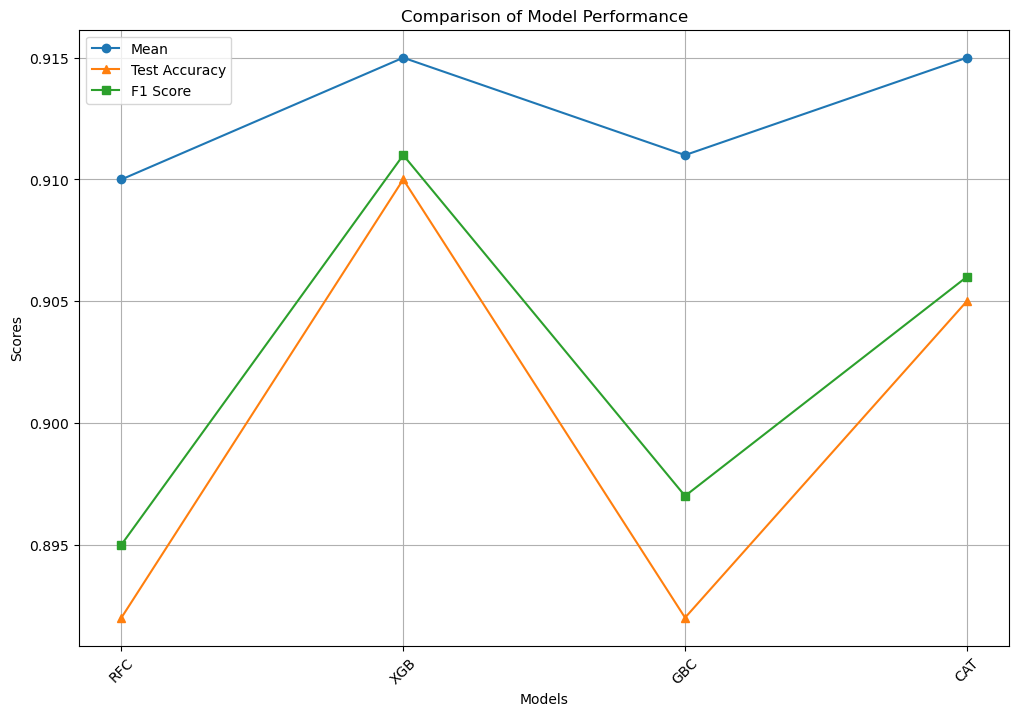

,Model,Mean,Var,STD,Test-Acc,recall-Score,precision-Score,F1-Score
1,XGB,0.915,0.0,0.010,0.910,0.910,0.911,0.911
3,CAT,0.915,0.0,0.010,0.905,0.905,0.907,0.906
2,GBC,0.911,0.0,0.010,0.892,0.892,0.906,0.897
0,RFC,0.910,0.0,0.011,0.892,0.892,0.899,0.895


In [41]:
model_names = ["RFC", "XGB", "GBC", "CAT"]
models = grab_selected_models(model_names)
test_selected_models(preprocessor,model_names, models, X, y_encoded, precision_metric, sample_model, kbest)

# Hyper Parameter Tuning

In [45]:
params = {
    'GBC': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__min_samples_split': [2, 4],
        'model__min_samples_leaf': [1, 2]
    },
    'XGB': {
        'model__n_estimators': [100, 150, 200, 300],
        'model__learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1],
        'model__max_depth': [3, 5, 7, 9],
        'model__subsample': [0.3, 0.4, 0.5, 0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0]
    },
    'RFC': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'SVC': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto'],
        'model__degree': [2, 3, 4]
    },
    "CAT":{
    'model__iterations': [100, 500, 1000],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [4, 6, 10],
    'model__l2_leaf_reg': [1, 3, 5, 7],
    'model__border_count': [32, 64, 128],
    'model__loss_function': ['Logloss', 'CrossEntropy'],
    'model__boosting_type': ['Plain'],
    'model__bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
    'model__grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
}
}

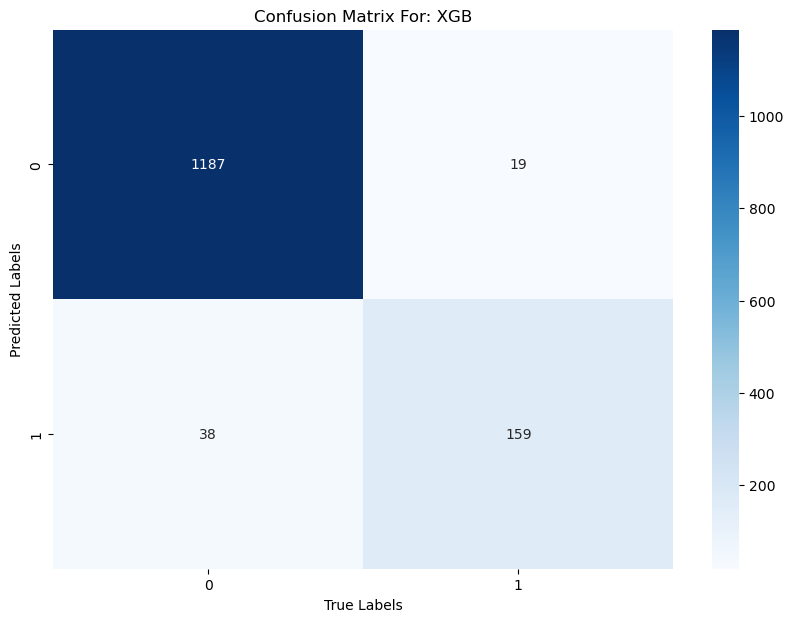

The Best Param: {'model__subsample': 1.0, 'model__n_estimators': 300, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1.0}


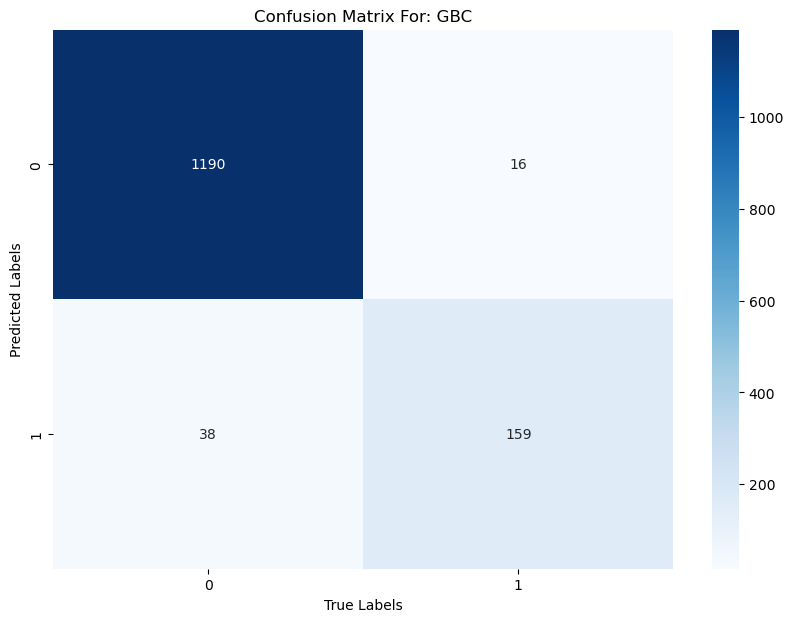

The Best Param: {'model__n_estimators': 200, 'model__min_samples_split': 4, 'model__min_samples_leaf': 1, 'model__max_depth': 5, 'model__learning_rate': 0.2}


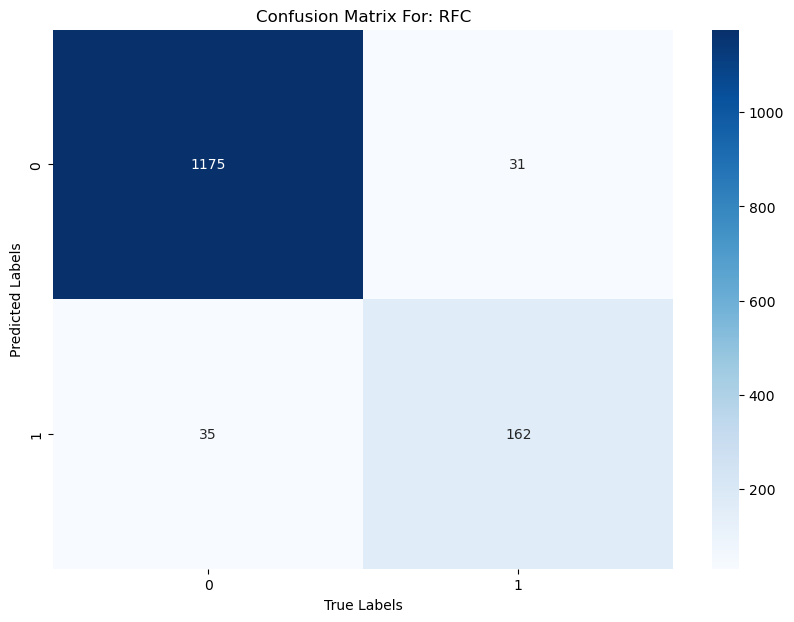

The Best Param: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_depth': 20}


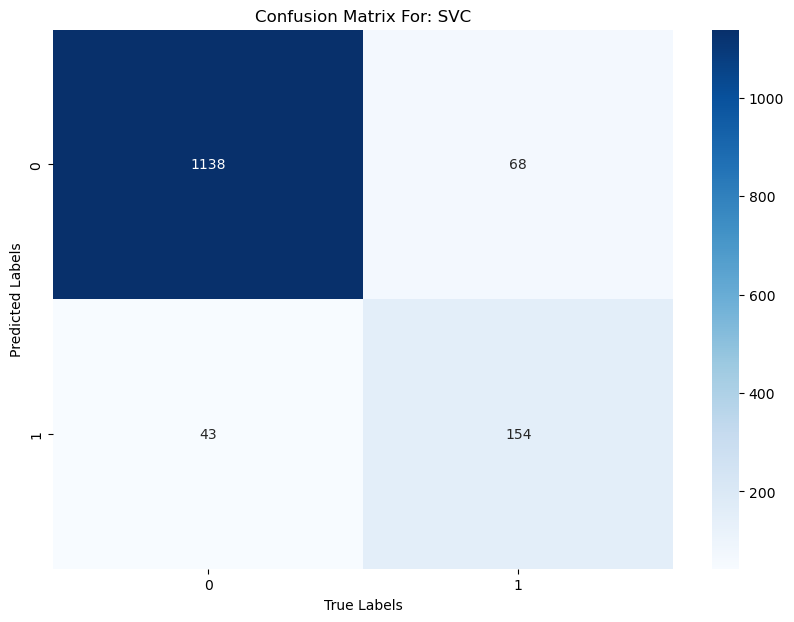

The Best Param: {'model__kernel': 'rbf', 'model__gamma': 'auto', 'model__degree': 2, 'model__C': 10}


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


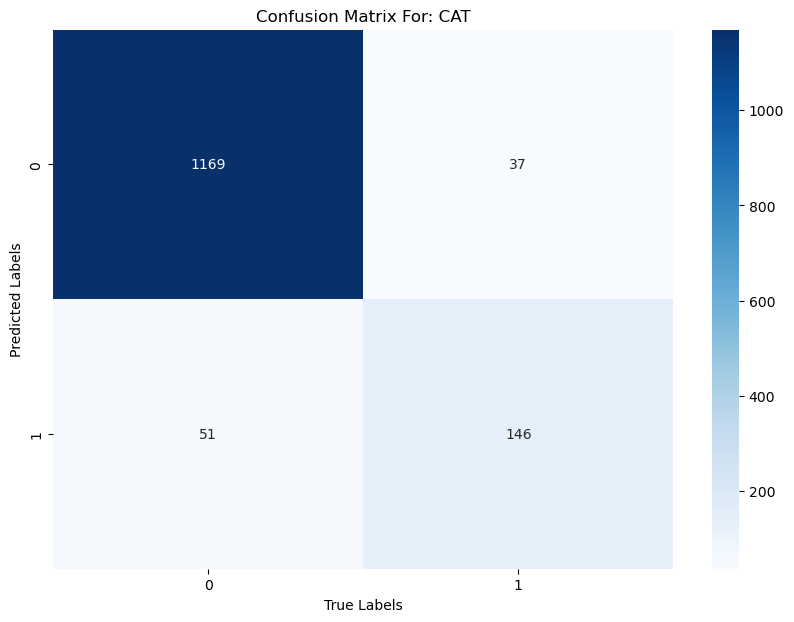

The Best Param: {'model__loss_function': 'Logloss', 'model__learning_rate': 0.1, 'model__l2_leaf_reg': 5, 'model__iterations': 1000, 'model__grow_policy': 'Lossguide', 'model__depth': 6, 'model__border_count': 32, 'model__bootstrap_type': 'Bayesian', 'model__boosting_type': 'Plain'}


,Model,Test-Acc,F1-Score,recall-Score,precision-Score
1,GBC,0.961511,0.960547,0.961511,0.960563
0,XGB,0.959373,0.958502,0.959373,0.958347
2,RFC,0.952958,0.952756,0.952958,0.952582
4,CAT,0.937277,0.936303,0.937277,0.935677
3,SVC,0.920884,0.922830,0.920884,0.925693


In [46]:
model_names = ["XGB", "GBC", "RFC", "SVC", "CAT"]
models = grab_selected_models(model_names)
performance_df, best_models = optimization_search(preprocessor, sample_model, model_names, models, X, y_encoded, RandomizedSearchCV, params, f1_metric, kbest)
performance_df.sort_values(by="precision-Score", ascending=False)

In [ ]:
["XGB", "GBC", "RFC", "SVC", "CAT"]

In [47]:
stack = [
  ("XGB",best_models[0]), 
  ("GBC", best_models[1]), 
  ("RFC", best_models[2]), 
  ("CAT", best_models[4]), 
  ("SVC", best_models[3]),
  ]

# Ensemble Learning

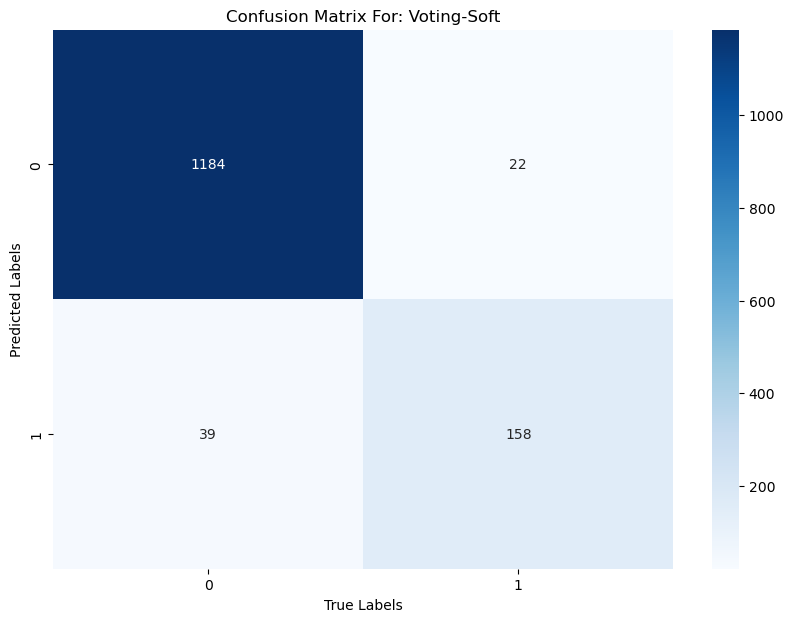

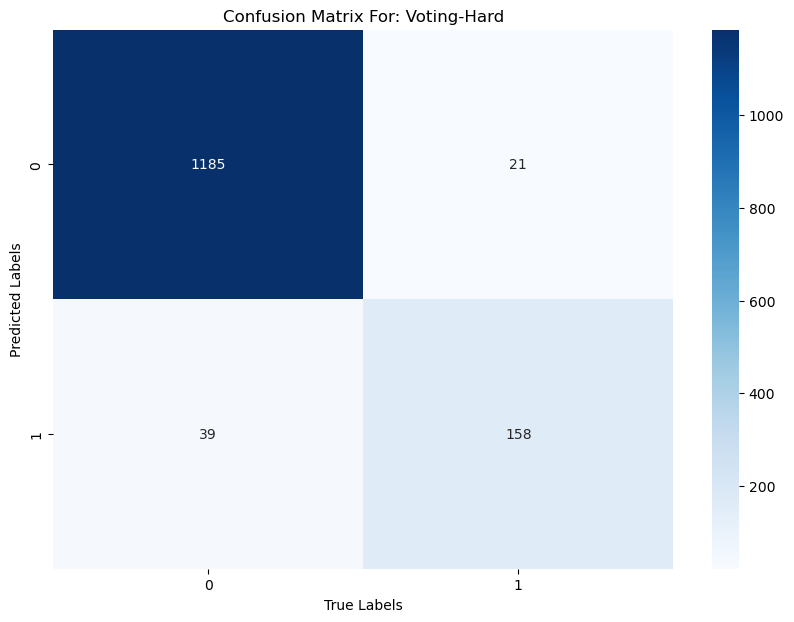

,Model,Test-Acc,F1-Score,recall-Score,precision-Score
1,Voting-Hard,0.957234,0.956369,0.957234,0.956138
0,Voting-Soft,0.956522,0.955694,0.956522,0.955427


In [48]:
voting_hard_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0]
  ],
  voting="hard"
)

voting_soft_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0]
  ],
  voting="soft"
)

models = [voting_soft_clf, voting_hard_clf]
model_names = ["Voting-Soft", "Voting-Hard"]

test_stacking_models(X, y_encoded, models, model_names)

In [52]:
voting_one_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0],
  stack[3],
  stack[1]
  ],
  voting="hard"
)

voting_two_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0],
  stack[1]
  ],
  voting="hard"
)

voting_three_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0],
  stack[3]
  ],
  voting="soft"
)

voting_four_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0],
  stack[3],
  stack[1]
  ],
  voting="soft"
)

models = [voting_one_clf, voting_two_clf, voting_three_clf, voting_four_clf]
model_names = ["Voting-One", "Voting-Two", "Voting-Three", "Voting-Four"]

test_stacking_models(X, y_encoded, models, model_names)

In [ ]:
xgb_clf = stack[0][1]
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.33, random_state=42)

xgb_clf.fit(X_train, y_train)
transformed_features = get_feature_names(xgb_clf.named_steps['preprocessor'])
selected_mask = xgb_clf.named_steps['Feature Selection'].get_support()

feature_importances = xgb_clf.named_steps['model'].feature_importances_
all_features = [feature for is_selected, feature in zip(xgb_clf.named_steps['Feature Selection'].get_support(), transformed_features)]


selected_features = [feature for feature, selected in zip(all_features, selected_mask) if selected]
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], color='b')
plt.xticks(range(len(feature_importances)), [all_features[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()